In [1]:
import sys
import warnings
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from shapely.geometry import Polygon, LineString, Point  # 공간 정보 처리

warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.5f}'.format

In [4]:
print("Python version :", sys.version)
print("Numpy version :", np.__version__)
print("Pandas version :", pd.__version__)
print("Scipy version :", scipy.__version__)
print("Geopandas version :", gpd.__version__)

Python version : 3.11.3 | packaged by Anaconda, Inc. | (main, May 15 2023, 15:41:31) [MSC v.1916 64 bit (AMD64)]
Numpy version : 1.26.2
Pandas version : 2.1.3
Scipy version : 1.11.3
Geopandas version : 0.14.1


## 데이터 확인 및 전처리

In [2]:
# 학습 데이터 불러오기

df_train = pd.read_csv("./data/train.csv")

df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


In [21]:
# 컬럼별 데이터 라벨 확인

df_train.nunique()

ID             39609
사고일시           18057
요일                 7
기상상태               6
시군구              199
도로형태              11
노면상태               6
사고유형               3
사고유형 - 세부분류       14
법규위반              11
가해운전자 차종          12
가해운전자 성별           3
가해운전자 연령          89
가해운전자 상해정도         6
피해운전자 차종          13
피해운전자 성별           3
피해운전자 연령          97
피해운전자 상해정도         6
사망자수               3
중상자수               7
경상자수              18
부상자수               9
ECLO              46
dtype: int64

In [3]:
# 테스트 데이터 데이터 확인

df_test = pd.read_csv("./data/test.csv")

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    10963 non-null  object
dtypes: object(8)
memory usage: 685.3+ KB


In [24]:
# 테스트 데이터 라벨 확인

df_test.nunique()

ID      10963
사고일시     5548
요일          7
기상상태        5
시군구       192
도로형태       11
노면상태        6
사고유형        3
dtype: int64

In [29]:
# train-test 중 겹치는 컬럼의 데이터 라벨 확인

col_test = df_test.columns[1:]

for c in col_test : 
    print(c+"의 train unique")
    print(sorted(df_train[c].unique().tolist()))
    print("-----------------------")
    print(c+"의 test unique")
    print(sorted(df_test[c].unique().tolist()))
    print("********************")


# 시군구의 경우 test에 존재하는 값이 train에 전부 존재하는지 확인

사고일시의 train unique
['2019-01-01 00', '2019-01-01 01', '2019-01-01 02', '2019-01-01 04', '2019-01-01 05', '2019-01-01 06', '2019-01-01 10', '2019-01-01 11', '2019-01-01 14', '2019-01-01 18', '2019-01-01 19', '2019-01-01 20', '2019-01-01 22', '2019-01-02 01', '2019-01-02 02', '2019-01-02 07', '2019-01-02 08', '2019-01-02 10', '2019-01-02 11', '2019-01-02 13', '2019-01-02 14', '2019-01-02 15', '2019-01-02 16', '2019-01-02 17', '2019-01-02 18', '2019-01-02 19', '2019-01-02 20', '2019-01-02 22', '2019-01-02 23', '2019-01-03 00', '2019-01-03 02', '2019-01-03 03', '2019-01-03 05', '2019-01-03 07', '2019-01-03 08', '2019-01-03 10', '2019-01-03 11', '2019-01-03 12', '2019-01-03 13', '2019-01-03 14', '2019-01-03 15', '2019-01-03 17', '2019-01-03 18', '2019-01-03 19', '2019-01-03 20', '2019-01-03 21', '2019-01-03 22', '2019-01-03 23', '2019-01-04 00', '2019-01-04 01', '2019-01-04 04', '2019-01-04 05', '2019-01-04 06', '2019-01-04 07', '2019-01-04 08', '2019-01-04 10', '2019-01-04 11', '2019-01-04

In [36]:
uni_city = df_test["시군구"].unique().tolist()

len_city_test = len(uni_city)

len_city_train = len(df_train[df_train["시군구"].isin(uni_city)]["시군구"].unique())

if len_city_test == len_city_train : 
    print("test data의 시군구 값은 train data에 전부 속합니다.")

test data의 시군구 값은 train data에 전부 속합니다.


In [4]:
# 사고 일시 object -> datetime

df_train["사고일시"] = pd.to_datetime(df_train["사고일시"], format="%Y-%m-%d %H")
df_test["사고일시"] = pd.to_datetime(df_test["사고일시"], format="%Y-%m-%d %H")

print(df_train["사고일시"].dtypes)
print(df_test["사고일시"].dtypes)

datetime64[ns]
datetime64[ns]


In [46]:
# 컬럼별 결측치 갯수 확인

df_train.isnull().sum()

ID               0
사고일시             0
요일               0
기상상태             0
시군구              0
도로형태             0
노면상태             0
사고유형             0
사고유형 - 세부분류      0
법규위반             0
가해운전자 차종         0
가해운전자 성별         0
가해운전자 연령         0
가해운전자 상해정도       0
피해운전자 차종       991
피해운전자 성별       991
피해운전자 연령       991
피해운전자 상해정도     991
사망자수             0
중상자수             0
경상자수             0
부상자수             0
ECLO             0
dtype: int64

결측치의 대부분이 피해 운전자이므로, 결측치가 존재하는 데이터의 사고 유형 등을 확인

In [52]:
df_train_null = df_train[df_train["피해운전자 차종"].isnull()]

print("null인 데이터의 사고 종류 :",df_train_null["사고유형"].unique())
print("null인 데이터의 상해 정도 종류 :",df_train_null["가해운전자 상해정도"].unique())

# 차량 단독으로 일어난 사고이므로 피해자가 없음, 차량 단독이지만 상해 종류는 다양

null인 데이터의 사고 종류 : ['차량단독']
null인 데이터의 상해 정도 종류 : ['중상' '경상' '상해없음' '부상신고' '사망' '기타불명']


In [53]:
# '차량 단독'이 전체 데이터 중 어느 정도 비율을 차지하는지 확인

df_train["사고유형"].value_counts()

사고유형
차대차     31785
차대사람     6833
차량단독      991
Name: count, dtype: int64

차량 단독의 전체 개수가 null 값인 사고 유형의 갯수와 일치하므로, 차량 단독 데이터를 제거할 수 없고 결측치 처리 필요

In [5]:
# 피해 운전자 관련 데이터의 label 확인

pihae = ['피해운전자 차종','피해운전자 성별','피해운전자 연령','피해운전자 상해정도']

for i in range(4) : 
    print(df_train[pihae[i]].unique())
    print("--------------------------")


# null 값을 '기타불명', '미분류' 등으로 대체

['보행자' '승용' '자전거' '승합' nan '이륜' '화물' '개인형이동수단(PM)' '사륜오토바이(ATV)' '특수'
 '원동기' '기타불명' '건설기계' '농기계']
--------------------------
['여' '남' nan '기타불명']
--------------------------
['70세' '61세' '38세' '36세' '52세' '35세' '76세' '53세' '62세' '42세' '60세' '69세'
 '31세' '23세' nan '57세' '17세' '54세' '55세' '64세' '41세' '44세' '58세' '45세'
 '30세' '59세' '34세' '68세' '32세' '21세' '56세' '18세' '37세' '39세' '27세' '65세'
 '43세' '12세' '75세' '4세' '71세' '40세' '48세' '14세' '19세' '66세' '63세' '50세'
 '20세' '67세' '26세' '22세' '47세' '16세' '28세' '46세' '51세' '29세' '33세' '24세'
 '79세' '80세' '74세' '78세' '72세' '49세' '73세' '5세' '13세' '77세' '9세' '86세'
 '15세' '84세' '25세' '82세' '10세' '8세' '85세' '7세' '11세' '88세' '미분류' '87세'
 '83세' '90세 이상' '3세' '81세' '6세' '89세' '2세' '1세' '91세' '90세' '93세' '94세'
 '92세' '98세 이상']
--------------------------
['중상' '경상' '상해없음' nan '부상신고' '사망' '기타불명']
--------------------------


In [6]:
# 결측치 채움

fill = ["기타불명", "기타불명", "미분류", "기타불명"]

for i in range(4) : 
    df_train[pihae[i]].fillna(fill[i], inplace=True)

df_train.isnull().sum()

ID             0
사고일시           0
요일             0
기상상태           0
시군구            0
도로형태           0
노면상태           0
사고유형           0
사고유형 - 세부분류    0
법규위반           0
가해운전자 차종       0
가해운전자 성별       0
가해운전자 연령       0
가해운전자 상해정도     0
피해운전자 차종       0
피해운전자 성별       0
피해운전자 연령       0
피해운전자 상해정도     0
사망자수           0
중상자수           0
경상자수           0
부상자수           0
ECLO           0
dtype: int64

In [7]:
# 가해 연령 / 피해 연령 범주화

df_train["가해연령_수정"] = df_train["가해운전자 연령"].str.extract(r"([0-9]+)세")
df_train["피해연령_수정"] = df_train["피해운전자 연령"].str.extract(r"([0-9]+)세")

df_train[["가해연령_수정","피해연령_수정"]] = df_train[["가해연령_수정","피해연령_수정"]].fillna('9999')  # 미분류의 경우 숫자 분리가 안 돼 NaN을 반환하므로, 임의의 숫자를 채움

df_train[["가해연령_수정","피해연령_수정"]] = df_train[["가해연령_수정","피해연령_수정"]].astype(int)

df_train["가해연령대"] = pd.cut(x=df_train["가해연령_수정"], bins=[0,10,20,30,40,50,60,70,80,90,100,150,10000], 
                           labels=["영유아", "10대", "20대", "30대", "40대", "50대", "60대", "70", "80대", "90대", "100세 이상", "미분류"],   # 연령대를 범주화
                           include_lowest=True)

df_train["피해연령대"] = pd.cut(x=df_train["피해연령_수정"], bins=[0,10,20,30,40,50,60,70,80,90,100,150,10000], 
                           labels=["영유아", "10대", "20대", "30대", "40대", "50대", "60대", "70", "80대", "90대", "100세 이상", "미분류"],
                           include_lowest=True)

df_train[df_train["가해연령_수정"]==9999]

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,가해연령_수정,피해연령_수정,가해연령대,피해연령대
11,ACCIDENT_00011,2019-01-01 14:00:00,화요일,맑음,대구광역시 동구 신기동,교차로 - 교차로안,건조,차대차,기타,안전운전불이행,...,경상,0,0,1,0,3,9999,69,미분류,60대
38,ACCIDENT_00038,2019-01-02 15:00:00,수요일,맑음,대구광역시 서구 이현동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,부상신고,0,0,0,1,1,9999,32,미분류,30대
83,ACCIDENT_00083,2019-01-03 20:00:00,목요일,맑음,대구광역시 북구 태전동,단일로 - 기타,건조,차대차,측면충돌,안전운전불이행,...,중상,0,1,0,0,5,9999,66,미분류,60대
145,ACCIDENT_00145,2019-01-05 17:00:00,토요일,맑음,대구광역시 북구 산격동,단일로 - 기타,건조,차대사람,기타,안전운전불이행,...,경상,0,0,1,0,3,9999,36,미분류,30대
186,ACCIDENT_00186,2019-01-07 02:00:00,월요일,맑음,대구광역시 달서구 진천동,단일로 - 기타,건조,차대차,기타,안전운전불이행,...,부상신고,0,0,0,1,1,9999,56,미분류,50대
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39486,ACCIDENT_39486,2021-12-28 13:00:00,화요일,맑음,대구광역시 달서구 진천동,단일로 - 기타,건조,차대사람,기타,안전운전불이행,...,경상,0,0,1,0,3,9999,64,미분류,60대
39518,ACCIDENT_39518,2021-12-29 16:00:00,수요일,맑음,대구광역시 수성구 범어동,단일로 - 기타,건조,차대사람,기타,안전운전불이행,...,경상,0,0,1,0,3,9999,13,미분류,10대
39540,ACCIDENT_39540,2021-12-30 11:00:00,목요일,맑음,대구광역시 수성구 범어동,단일로 - 기타,건조,차대차,기타,안전운전불이행,...,상해없음,0,0,1,0,3,9999,35,미분류,30대
39578,ACCIDENT_39578,2021-12-31 12:00:00,금요일,맑음,대구광역시 달성군 구지면,단일로 - 기타,건조,차대차,기타,안전거리미확보,...,경상,0,0,1,0,3,9999,30,미분류,20대


### 외부 데이터 불러오기

In [99]:
# cctv 데이터

cctv = pd.read_csv("./data/external_open/대구 CCTV 정보.csv", encoding='cp949')

cctv.info()
# cctv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   무인교통단속카메라관리번호  1065 non-null   object 
 1   시도명            1065 non-null   object 
 2   시군구명           1065 non-null   object 
 3   도로종류           1065 non-null   object 
 4   도로노선번호         288 non-null    object 
 5   도로노선명          1065 non-null   object 
 6   도로노선방향         1065 non-null   int64  
 7   소재지도로명주소       905 non-null    object 
 8   소재지지번주소        1065 non-null   object 
 9   위도             1065 non-null   float64
 10  경도             1065 non-null   float64
 11  설치장소           1065 non-null   object 
 12  단속구분           1065 non-null   int64  
 13  제한속도           1065 non-null   int64  
 14  단속구간위치구분       53 non-null     float64
 15  과속단속구간길이       26 non-null     float64
 16  보호구역구분         893 non-null    float64
 17  설치연도           1065 non-null   int64  
dtypes: float

In [25]:
cctv[["단속구분", "제한속도"]].value_counts().sort_index(ascending=False).to_frame()

count
단속구분 제한속도       
99   100      16
     80       25
     60        2
     50        4
     40        2
     30        2
4    0       232
2    80        3
     70       13
     60      126
     50      218
     40       67
     30      148
1    110       1
     100       3
     80        4
     70        9
     60       59
     50       52
     40       11
     30       68

보통 제한 속도를 보면서 운전을 하는 것이 아니라 cctv가 있을 때 속도를 줄이므로,  
단속 구분과 제한 속도는 의미가 없고 행정 구역별 갯수가 유의미할 것으로 판단

In [64]:
# 보안등 데이터

light = pd.read_csv("./data/external_open/대구 보안등 정보.csv", encoding='cp949')

light.info()
# light.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71913 entries, 0 to 71912
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   보안등위치명    71913 non-null  object 
 1   설치개수      71913 non-null  int64  
 2   소재지도로명주소  34646 non-null  object 
 3   소재지지번주소   71913 non-null  object 
 4   위도        43602 non-null  float64
 5   경도        43602 non-null  float64
 6   설치연도      29397 non-null  float64
 7   설치형태      35373 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 4.4+ MB


In [98]:
wrong_address = light[light["주소_수정"].str.contains(r"대구광역시\s[ㄱ-힣]+구\s[ㄱ-힣]+[0-9]+[^가^동\.·]")]

# light.loc[wrong_address.index, "주소_수정"] = 
light.loc[wrong_address.index, "주소_수정"]

7611     대구광역시 달서구 이곡동1231-6
8040      대구광역시 달서구 성당동527-1
8041      대구광역시 달서구 성당동527-1
8042        대구광역시 달서구 성당동526
8043        대구광역시 달서구 성당동526
                ...         
17281     대구광역시 달서구 성당동658-1
17282     대구광역시 달서구 성당동658-6
26663        대구광역시 동구 도평로131
28449      대구광역시 동구 팔공로355-3
35102      대구광역시 동구 부동길162-5
Name: 주소_수정, Length: 816, dtype: object

보안등 데이터의 주소의 전처리 시간이 오래 걸리므로,  
  
일단 보류

In [100]:
# 어린이 보호 구역 데이터

child = pd.read_csv("./data/external_open/대구 어린이 보호 구역 정보.csv", encoding='cp949')

child.info()
# child.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시설종류      640 non-null    object 
 1   대상시설명     640 non-null    object 
 2   소재지도로명주소  640 non-null    object 
 3   소재지지번주소   640 non-null    object 
 4   위도        640 non-null    float64
 5   경도        640 non-null    float64
 6   관리기관명     640 non-null    object 
 7   관할경찰서명    640 non-null    object 
 8   CCTV설치여부  640 non-null    object 
 9   CCTV설치대수  465 non-null    float64
 10  보호구역도로폭   320 non-null    object 
 11  데이터기준일자   640 non-null    object 
dtypes: float64(3), object(9)
memory usage: 60.1+ KB


In [101]:
# cctv 설치여부 Y -> 1, N -> 0으로 변경

child["CCTV설치여부"].replace({"Y":1, "N":0}, inplace=True)

child["CCTV설치여부"].unique()

array([1, 0], dtype=int64)

In [34]:
data_sch = child["대상시설명"].value_counts()

data_sch

대상시설명
죽곡어린이집         2
화원초등           2
죽곡초등           2
천내초등           2
하빈면초등          2
              ..
관문초등           1
대구과학대학부설유치원    1
달산초등           1
다솜유치원          1
동화나라어린이집       1
Name: count, Length: 538, dtype: int64

In [37]:
child[child["대상시설명"]=="화원초등"]

# 동일한 데이터가 2개

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자
95,초등학교,화원초등,대구광역시 달성군 화원읍 비슬로 2580,대구광역시 달성군 화원읍 천내리 417,35.803331,128.499624,대구광역시 달성군청,달성경찰서,1,2.0,NaN,2019-09-10
194,초등학교,화원초등,대구광역시 달성군 화원읍 비슬로 2580,대구광역시 달성군 화원읍 천내리 417,35.803331,128.499624,대구광역시 달성군청,달성경찰서,1,2.0,NaN,2019-09-10


In [38]:
date_date_child = child[["대상시설명","데이터기준일자"]].value_counts()

date_date_child

# 이름은 같지만 데이터기준일자가 다른 데이터가 존재

대상시설명     데이터기준일자   
죽곡초교병설    2019-09-10    2
자연숲유치원    2019-09-10    2
동곡초등학교병설  2019-09-10    2
천내초등      2019-09-10    2
천내어린이집    2019-09-10    2
                       ..
무열대유치원    2019-12-27    1
무산유치원     2020-01-14    1
모란어린이집    2019-12-27    1
명지어린이집    2020-01-14    1
효신초교      2020-01-14    1
Name: count, Length: 541, dtype: int64

In [39]:
print("대상시설명과 데이터기준일자에 따른 데이터 총합 =", date_date_child.sum())

대상시설명과 데이터기준일자에 따른 데이터 총합 = 640


In [102]:
child_dr = child.drop_duplicates(subset=["대상시설명","데이터기준일자"], keep="first")   # 동일한 데이터를 삭제

child_dr[["대상시설명","데이터기준일자"]].value_counts()

대상시설명    데이터기준일자   
DGB어린이집  2019-12-27    1
영선초등학교   2020-03-23    1
옥빛유치원    2019-09-10    1
예지원어린이집  2019-12-27    1
예일유치원    2019-12-17    1
                      ..
만촌초등학교   2019-12-27    1
만촌어린이집   2019-12-27    1
마리아유치원   2019-12-27    1
리오바어린이집  2019-12-27    1
효신초교     2020-01-14    1
Name: count, Length: 541, dtype: int64

In [17]:
child_dr[child_dr["대상시설명"]=="꿈나무어린이집"]

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자
509,어린이집,꿈나무어린이집,대구광역시 수성구 들안로2안길 27-15(두산동),대구광역시 수성구 두산동 159-1,35.832741,128.619288,대구광역시 수성구,수성경찰서,1,NaN,NaN,2019-12-27
639,어린이집,꿈나무어린이집,대구광역시 중구 남산로7길 35,대구광역시 중구 남산동 2508-2,35.858483,128.580584,대구광역시 중구청,대구광역시 중부경찰서,1,4.0,7~11,2019-06-01


이름이 같고 주소가 다른 어린이집이 존재

In [40]:
print("중복을 제거한 대상시설명과 데이터기준일자에 따른 데이터 총합 =", child_dr[["대상시설명","데이터기준일자"]].value_counts().sum())

중복을 제거한 대상시설명과 데이터기준일자에 따른 데이터 총합 = 541


어린이 보호 구역에 cctv 여부는 중요할 것으로 판단(cctv가 존재할 때 속도를 줄일 것이기에).

In [13]:
# # 주차장 데이터

# parking = pd.read_csv("./data/external_open/대구 주차장 정보.csv", encoding='cp949')

# parking.info()
# # parking.head()

---

In [103]:
# 각 외부 데이터의 주소를 번지수 이전까지만 표현

# cctv["주소_수정"] = cctv["소재지지번주소"].str.extract(r'(대구광역시\s[ㄱ-힣]+\s[ㄱ-힣]+)\s')
# light["주소_수정"] = light["소재지지번주소"].str.extract(r'(대구광역시\s[ㄱ-힣]+\s[ㄱ-힣]+)\s')
# child_dr["주소_수정"] = child_dr["소재지지번주소"].str.extract(r'(대구광역시\s[ㄱ-힣]+\s[ㄱ-힣]+)\s')

cctv["주소_수정"] = cctv["소재지지번주소"].map(lambda x : " ".join(x.split()[:3]))
# light["주소_수정"] = light["소재지지번주소"].map(lambda x : " ".join(x.split()[:3]))
child_dr["주소_수정"] = child_dr["소재지지번주소"].map(lambda x : " ".join(x.split()[:3]))

child_dr["주소_수정"]

0      대구광역시 남구 대명동
1      대구광역시 남구 이천동
2      대구광역시 남구 대명동
3      대구광역시 남구 대명동
4      대구광역시 남구 대명동
           ...     
635    대구광역시 중구 남산동
636    대구광역시 중구 봉산동
637    대구광역시 중구 남산동
638    대구광역시 중구 남산동
639    대구광역시 중구 남산동
Name: 주소_수정, Length: 541, dtype: object

---

In [104]:
# 주소별로 지역별 전체 cctv 갯수 파악

gb_cctv = cctv.groupby("주소_수정")["주소_수정"].count().sort_values(ascending=False)

gb_cctv.index.rename("",inplace=True)

gb_cctv = gb_cctv.to_frame()

gb_cctv.reset_index(level=0,inplace=True)

gb_cctv.columns = ["주소_수정", "주소별 cctv 수"]

gb_cctv

,주소_수정,주소별 cctv 수
0,대구광역시 남구 대명동,62
1,대구광역시 달성군 다사읍,52
2,대구광역시 달성군 화원읍,39
3,대구광역시 달서구 용산동,33
4,대구광역시 달서구 상인동,30
...,...,...
169,대구광역시 북구 동변동,1
170,대구광역시 북구 노원동2가,1
171,대구광역시 북구 노원동1가,1
172,대구광역시 북구 고성동3가,1


In [105]:
# 주소별 어린이 보호구역 개수 파악

gb_child_dr = child_dr.groupby("주소_수정")[["주소_수정", "CCTV설치여부"]].agg({"주소_수정":["count"], "CCTV설치여부":["sum"]}).sort_index(axis=0, level=0)

gb_child_dr.columns = ["주소별 어린이 보호구역 수", "주소별 어린이 보호구역 cctv 수"]

gb_child_dr.reset_index(inplace=True)

gb_child_dr

,주소_수정,주소별 어린이 보호구역 수,주소별 어린이 보호구역 cctv 수
0,대구광역시 남구 대명동,26,26
1,대구광역시 남구 봉덕동,8,8
2,대구광역시 남구 이천동,6,6
3,대구광역시 달성군 가창면,4,0
4,대구광역시 달성군 구지면,3,1
...,...,...,...
90,대구광역시 중구 봉산동,2,2
91,대구광역시 중구 삼덕동2가,1,1
92,대구광역시 중구 삼덕동3가,1,1
93,대구광역시 중구 서문로1가,1,1


In [106]:
# 주소별 보안등 정보

# gb_light = light.groupby("주소_수정")["주소_수정"].count().sort_values(ascending=False)

# gb_light.index.rename("",inplace=True)

# gb_light = gb_light.to_frame()

# gb_light.reset_index(level=0,inplace=True)

# gb_light.columns = ["주소_수정", "주소별 보안등 수"]

# gb_light

In [114]:
# 데이터 합치기 

gbList = ["cctv", "child_dr"]

# cnt = 1
for i in range(2) : 
    # print(cnt)
    
    if i == 0 :
        df_train_join = pd.merge(df_train, globals()["gb_"+gbList[i]], how="left", left_on="시군구", right_on="주소_수정")
    else : 
        df_train_join = pd.merge(df_train_join, globals()["gb_"+gbList[i]], how="left", left_on="시군구", right_on="주소_수정")

    # cnt+=1

df_train_join.drop(["주소_수정_x","주소_수정_y"], axis=1, inplace=True)

df_train_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   39609 non-null  object        
 1   사고일시                 39609 non-null  datetime64[ns]
 2   요일                   39609 non-null  object        
 3   기상상태                 39609 non-null  object        
 4   시군구                  39609 non-null  object        
 5   도로형태                 39609 non-null  object        
 6   노면상태                 39609 non-null  object        
 7   사고유형                 39609 non-null  object        
 8   사고유형 - 세부분류          39609 non-null  object        
 9   법규위반                 39609 non-null  object        
 10  가해운전자 차종             39609 non-null  object        
 11  가해운전자 성별             39609 non-null  object        
 12  가해운전자 연령             39609 non-null  object        
 13  가해운전자 상해정도           39609 non-

In [116]:
for i in range(2) : 
    # print(cnt)
    
    if i == 0 :
        df_test_join = pd.merge(df_test, globals()["gb_"+gbList[i]], how="left", left_on="시군구", right_on="주소_수정")
    else : 
        df_test_join = pd.merge(df_test_join, globals()["gb_"+gbList[i]], how="left", left_on="시군구", right_on="주소_수정")

    # cnt+=1

df_test_join.drop(["주소_수정_x", "주소_수정_y"], axis=1, inplace=True)

df_test_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   10963 non-null  object        
 1   사고일시                 10963 non-null  datetime64[ns]
 2   요일                   10963 non-null  object        
 3   기상상태                 10963 non-null  object        
 4   시군구                  10963 non-null  object        
 5   도로형태                 10963 non-null  object        
 6   노면상태                 10963 non-null  object        
 7   사고유형                 10963 non-null  object        
 8   주소별 cctv 수           10514 non-null  float64       
 9   주소별 어린이 보호구역 수       7368 non-null   float64       
 10  주소별 어린이 보호구역 cctv 수  7368 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 942.3+ KB


In [117]:
# 결측치를 전부 0으로 처리(∵ join 하면서 생긴 변수의 결측치가 숫자 타입이기 때문)

df_train_join.fillna(0, axis=1, inplace=True)

df_test_join.fillna(0, axis=1, inplace=True)

print(df_train_join.isnull().sum())
print(df_test_join.isnull().sum())

ID                     0
사고일시                   0
요일                     0
기상상태                   0
시군구                    0
도로형태                   0
노면상태                   0
사고유형                   0
사고유형 - 세부분류            0
법규위반                   0
가해운전자 차종               0
가해운전자 성별               0
가해운전자 연령               0
가해운전자 상해정도             0
피해운전자 차종               0
피해운전자 성별               0
피해운전자 연령               0
피해운전자 상해정도             0
사망자수                   0
중상자수                   0
경상자수                   0
부상자수                   0
ECLO                   0
가해연령_수정                0
피해연령_수정                0
가해연령대                  0
피해연령대                  0
주소별 cctv 수             0
주소별 어린이 보호구역 수         0
주소별 어린이 보호구역 cctv 수    0
dtype: int64
ID                     0
사고일시                   0
요일                     0
기상상태                   0
시군구                    0
도로형태                   0
노면상태                   0
사고유형                   0
주소별 cctv 수             0
주소별 어린이 보호구역

## EDA

In [119]:
# int 타입으로 변경

df_train_join[['사망자수','중상자수','경상자수','부상자수','ECLO','주소별 cctv 수','주소별 어린이 보호구역 수','주소별 어린이 보호구역 cctv 수']] = df_train_join[['사망자수','중상자수','경상자수','부상자수','ECLO','주소별 cctv 수','주소별 어린이 보호구역 수','주소별 어린이 보호구역 cctv 수']].astype(int)

df_train_join.dtypes

ID                     object
사고일시                   object
요일                     object
기상상태                   object
시군구                    object
도로형태                   object
노면상태                   object
사고유형                   object
사고유형 - 세부분류            object
법규위반                   object
가해운전자 차종               object
가해운전자 성별               object
가해운전자 연령               object
가해운전자 상해정도             object
피해운전자 차종               object
피해운전자 성별               object
피해운전자 연령               object
피해운전자 상해정도             object
사망자수                    int32
중상자수                    int32
경상자수                    int32
부상자수                    int32
ECLO                    int32
가해연령_수정                object
피해연령_수정                object
가해연령대                  object
피해연령대                  object
주소별 cctv 수              int32
주소별 어린이 보호구역 수          int32
주소별 어린이 보호구역 cctv 수     int32
dtype: object

In [120]:
# 숫자 타입의 통계치

df_train_join.describe()

,사망자수,중상자수,경상자수,부상자수,ECLO,주소별 cctv 수,주소별 어린이 보호구역 수,주소별 어린이 보호구역 cctv 수
count,39609.00000,39609.00000,39609.00000,39609.00000,39609.00000,39609.00000,39609.00000,39609.00000
mean,0.00778,0.26236,1.07009,0.12687,4.72670,13.65558,7.08617,6.08407
std,0.09011,0.50085,0.99203,0.39467,3.20721,14.35717,8.04504,7.20248
min,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,3.00000,4.00000,0.00000,0.00000
50%,0.00000,0.00000,1.00000,0.00000,3.00000,11.00000,5.00000,4.00000
75%,0.00000,0.00000,1.00000,0.00000,6.00000,15.00000,10.00000,9.00000
max,2.00000,6.00000,22.00000,10.00000,74.00000,62.00000,30.00000,26.00000


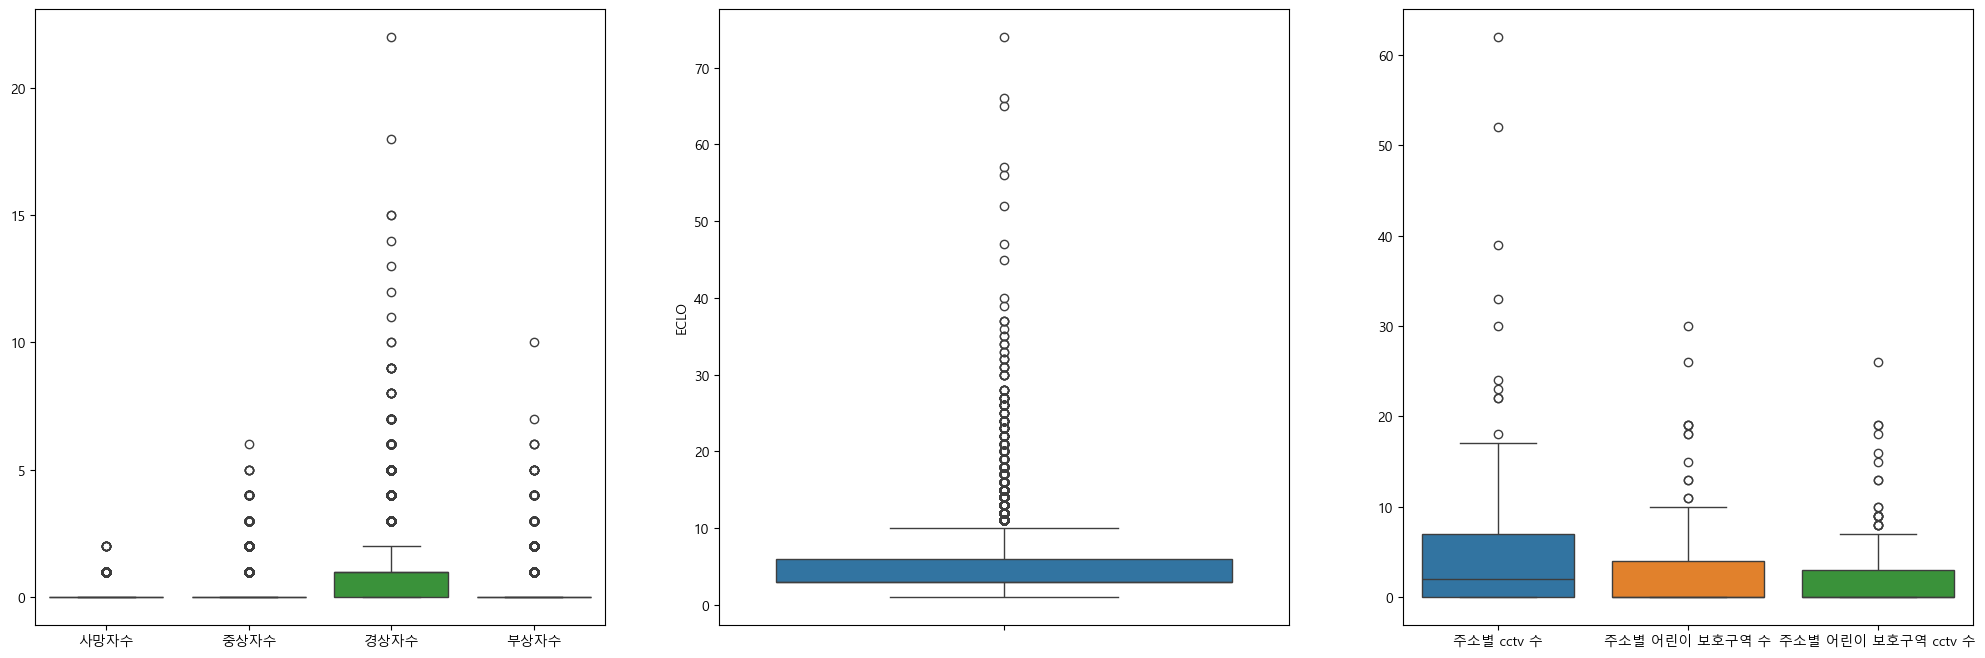

In [123]:
# 숫자 컬럼의 box-plot

fig, axes = plt.subplots(figsize=(25,8), nrows=1, ncols=3)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

add_infra = df_train_join.groupby("시군구")[["주소별 cctv 수", "주소별 어린이 보호구역 수",'주소별 어린이 보호구역 cctv 수']].mean()

sns.boxplot(df_train_join.select_dtypes("number").iloc[:,0:4], ax=axes[0])
sns.boxplot(df_train_join.select_dtypes("number").iloc[:,4], ax=axes[1])
sns.boxplot(add_infra[["주소별 cctv 수", "주소별 어린이 보호구역 수",'주소별 어린이 보호구역 cctv 수']], ax=axes[2])
plt.show()

"사망" 이란 교통사고 발생시로부터 30일이내에 사망한 경우. (99년까지는 72시간 이내)  
"중상" 이란 교통사고로 인하여 3주 이상의 치료를 요하는 부상을 입은 경우.  
"경상" 이란 교통사고로 인하여 5일 이상 3주 미만의 치료를 요하는 부상을 입은 경우.  
"부상신고" 란 교통사고로 인하여 5일 미만의 치료를 요하는 부상을 입은 경우.  

'측면 충돌'은 차가 옆에서 박은 것  
'추돌'은 뒤에서 박은 것(안전거리 미확보)  
'정면 추돌'은 앞에서 박은 것

---

사고에 따른 피해자 수를 살펴보면,  
  
사고에 따라 부상의 경우가 다르기 때문에 대부분의 값이 0인 경우를 알 수 있음(그렇기 때문에 피해자 수가 Q3 + 1.5iqr을 벗어나는 값이 많아 보임).  
  
그러나 차량의 수용 인원이나 주위의 유동 인구, 사고의 규모에 따라 피해자의 수가 달라짐을 확인할 수 있다.  
  
경상자의 경우 20명이 넘는 피해자가 있는 경우도 있는데, 아마 추돌 사고나 버스 등에 대형 차량에 의한 사고로 보인다.  
  
**ECLO = 사망자수 * 10 + 중상자수 * 5 + 경상자수 * 3 + 부상자수 * 1**  
  
ECLO 식은 위와 같은데,  
  
데이터 분포의 75%까지 10의 값인 것을 유추해보면  
  
사망자 1명 또는 중상자 2명, 경상자 3명, 부상자 10명 등으로 생각할 수 있다.  
  
부상과 경상까지 생각한다면 75% 정도가 큰 사고가 아님을 알 수 있지만,  
  
사망과 중상만으로도 ECLO 값이 10을 초과할 수 있기 때문에  
  
적어도 25% 사고는 절대 가볍다고 생각할 수 없는 사고일 것이다.

---

교통 사고 예방을 위한 인프라의 수를 살펴봤을 때,  
  
대부분은 좌로 치우친 그래프를 확인할 수 있는데 이는 각 지역의 인구수나 소득 수준에 비례할 것이라고 생각한다.  
  
인구 수에 비례한다고 했을 때 인구 밀도가 높지 않은 지역 혹은, 차량의 유입이 없는 지역은 cctv가 없을 가능성이 크다.

---

object 타입의 데이터 분포를 시각화 하기 전에 사고 일시를 월과 시간대로 나눠  
  
계절과 시간대를 구분하려고 한다.

In [124]:
# 사고 일시를 월과 시각으로 분리

df_train_join["사고일시"] = pd.to_datetime(df_train_join["사고일시"], format="%Y-%m-%d %H:%M:%S")

df_train_join["사고 월"] = df_train_join["사고일시"].dt.strftime("%m").astype(int)
df_train_join["사고 시각"] = df_train_join["사고일시"].dt.strftime("%H").astype(int)

df_train_join[["사고일시", "사고 월", "사고 시각"]]

,사고일시,사고 월,사고 시각
0,2019-01-01 00:00:00,1,0
1,2019-01-01 00:00:00,1,0
2,2019-01-01 01:00:00,1,1
3,2019-01-01 02:00:00,1,2
4,2019-01-01 04:00:00,1,4
...,...,...,...
39604,2021-12-31 19:00:00,12,19
39605,2021-12-31 19:00:00,12,19
39606,2021-12-31 21:00:00,12,21
39607,2021-12-31 22:00:00,12,22


In [125]:
# 분리된 월과 시각을 계절과 시간대로 변경

df_train_join["사고 계절"] = 0
df_train_join["사고 시간대"] = 0

for r in range(df_train_join.shape[0]) : 

    # 각 사고 월을 계절로 치환
    if (df_train_join.loc[r,"사고 월"] >= 3) & (df_train_join.loc[r,"사고 월"] < 6) : 
        df_train_join.loc[r,"사고 계절"] = "봄"
    elif (df_train_join.loc[r,"사고 월"] >= 6) & (df_train_join.loc[r,"사고 월"] < 9) : 
        df_train_join.loc[r,"사고 계절"] = "여름"
    elif (df_train_join.loc[r,"사고 월"] >= 9) & (df_train_join.loc[r,"사고 월"] < 12) : 
        df_train_join.loc[r,"사고 계절"] = "가을"
    else : 
        df_train_join.loc[r,"사고 계절"] = "겨울"

    
    # 각 사고 시각을 시간대로 치환
    if (df_train_join.loc[r,"사고 시각"] >= 0) & (df_train_join.loc[r,"사고 시각"] < 6) : 
        df_train_join.loc[r,"사고 시간대"] = "새벽"
    elif (df_train_join.loc[r,"사고 시각"] >= 6) & (df_train_join.loc[r,"사고 시각"] < 12) : 
        df_train_join.loc[r,"사고 시간대"] = "아침"
    elif (df_train_join.loc[r,"사고 시각"] >= 12) & (df_train_join.loc[r,"사고 시각"] < 18) : 
        df_train_join.loc[r,"사고 시간대"] = "점심"
    else : 
        df_train_join.loc[r,"사고 시간대"] = "저녁"

df_train_join[["사고일시", "사고 월", "사고 시각","사고 계절","사고 시간대"]]

,사고일시,사고 월,사고 시각,사고 계절,사고 시간대
0,2019-01-01 00:00:00,1,0,겨울,새벽
1,2019-01-01 00:00:00,1,0,겨울,새벽
2,2019-01-01 01:00:00,1,1,겨울,새벽
3,2019-01-01 02:00:00,1,2,겨울,새벽
4,2019-01-01 04:00:00,1,4,겨울,새벽
...,...,...,...,...,...
39604,2021-12-31 19:00:00,12,19,겨울,저녁
39605,2021-12-31 19:00:00,12,19,겨울,저녁
39606,2021-12-31 21:00:00,12,21,겨울,저녁
39607,2021-12-31 22:00:00,12,22,겨울,저녁


In [126]:
def season_time(dataframe) : 
    """
    사고 발생 시각을 범주화
    """

    dataframe["사고일시"] = pd.to_datetime(dataframe["사고일시"], format="%Y-%m-%d %H:%M:%S")

    dataframe["사고 월"] = dataframe["사고일시"].dt.strftime("%m").astype(int)
    dataframe["사고 시각"] = dataframe["사고일시"].dt.strftime("%H").astype(int)

    dataframe[["사고일시", "사고 월", "사고 시각"]]

    dataframe["사고 계절"] = 0
    dataframe["사고 시간대"] = 0

    for r in range(dataframe.shape[0]) : 

        # 각 사고 월을 계절로 치환
        if (dataframe.loc[r,"사고 월"] >= 3) & (dataframe.loc[r,"사고 월"] < 6) : 
            dataframe.loc[r,"사고 계절"] = "봄"
        elif (dataframe.loc[r,"사고 월"] >= 6) & (dataframe.loc[r,"사고 월"] < 9) : 
            dataframe.loc[r,"사고 계절"] = "여름"
        elif (dataframe.loc[r,"사고 월"] >= 9) & (dataframe.loc[r,"사고 월"] < 12) : 
            dataframe.loc[r,"사고 계절"] = "가을"
        else : 
            dataframe.loc[r,"사고 계절"] = "겨울"

        
        # 각 사고 시각을 시간대로 치환
        if (dataframe.loc[r,"사고 시각"] >= 0) & (dataframe.loc[r,"사고 시각"] < 6) : 
            dataframe.loc[r,"사고 시간대"] = "새벽"
        elif (dataframe.loc[r,"사고 시각"] >= 6) & (dataframe.loc[r,"사고 시각"] < 12) : 
            dataframe.loc[r,"사고 시간대"] = "아침"
        elif (dataframe.loc[r,"사고 시각"] >= 12) & (dataframe.loc[r,"사고 시각"] < 18) : 
            dataframe.loc[r,"사고 시간대"] = "점심"
        else : 
            dataframe.loc[r,"사고 시간대"] = "저녁"

    return dataframe

In [128]:
df_test_join = season_time(df_test_join)

df_test_join

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,주소별 cctv 수,주소별 어린이 보호구역 수,주소별 어린이 보호구역 cctv 수,사고 월,사고 시각,사고 계절,사고 시간대
0,ACCIDENT_39609,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람,4.00000,5.00000,5.00000,1,1,겨울,새벽
1,ACCIDENT_39610,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람,7.00000,10.00000,10.00000,1,1,겨울,새벽
2,ACCIDENT_39611,2022-01-01 04:00:00,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차,1.00000,1.00000,1.00000,1,4,겨울,새벽
3,ACCIDENT_39612,2022-01-01 04:00:00,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차,11.00000,7.00000,7.00000,1,4,겨울,새벽
4,ACCIDENT_39613,2022-01-01 06:00:00,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차,12.00000,0,0,1,6,겨울,아침
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,2022-12-31 18:00:00,토요일,맑음,대구광역시 남구 대명동,단일로 - 터널,건조,차대차,62.00000,26.00000,26.00000,12,18,겨울,저녁
10959,ACCIDENT_50568,2022-12-31 18:00:00,토요일,맑음,대구광역시 수성구 시지동,단일로 - 기타,건조,차대차,4.00000,5.00000,5.00000,12,18,겨울,저녁
10960,ACCIDENT_50569,2022-12-31 20:00:00,토요일,맑음,대구광역시 수성구 연호동,단일로 - 기타,건조,차대차,0,0,0,12,20,겨울,저녁
10961,ACCIDENT_50570,2022-12-31 20:00:00,토요일,맑음,대구광역시 수성구 범물동,교차로 - 교차로부근,건조,차대차,7.00000,7.00000,7.00000,12,20,겨울,저녁


In [127]:
object_select = df_train_join.select_dtypes("object").drop(["ID", "가해운전자 연령", "가해연령_수정", "피해운전자 연령", "피해연령_수정"], axis=1)  # object 타입의 컬럼만 추출

object_select

,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 상해정도,가해연령대,피해연령대,사고 계절,사고 시간대
0,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,상해없음,보행자,여,중상,50대,60대,겨울,새벽
1,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,상해없음,보행자,남,경상,30대,60대,겨울,새벽
2,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,남,상해없음,보행자,남,경상,60대,30대,겨울,새벽
3,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,상해없음,승용,남,중상,40대,30대,겨울,새벽
4,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,상해없음,승용,남,경상,20대,50대,겨울,새벽
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,금요일,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,승용,여,상해없음,이륜,남,경상,50대,20대,겨울,저녁
39605,금요일,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,승용,여,상해없음,승용,남,경상,50대,50대,겨울,저녁
39606,금요일,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,승용,남,중상,승용,남,중상,50대,70,겨울,저녁
39607,금요일,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,상해없음,승용,여,경상,30대,50대,겨울,저녁


object 타입의 히스토그램을 살펴보면

<function matplotlib.pyplot.show(close=None, block=None)>

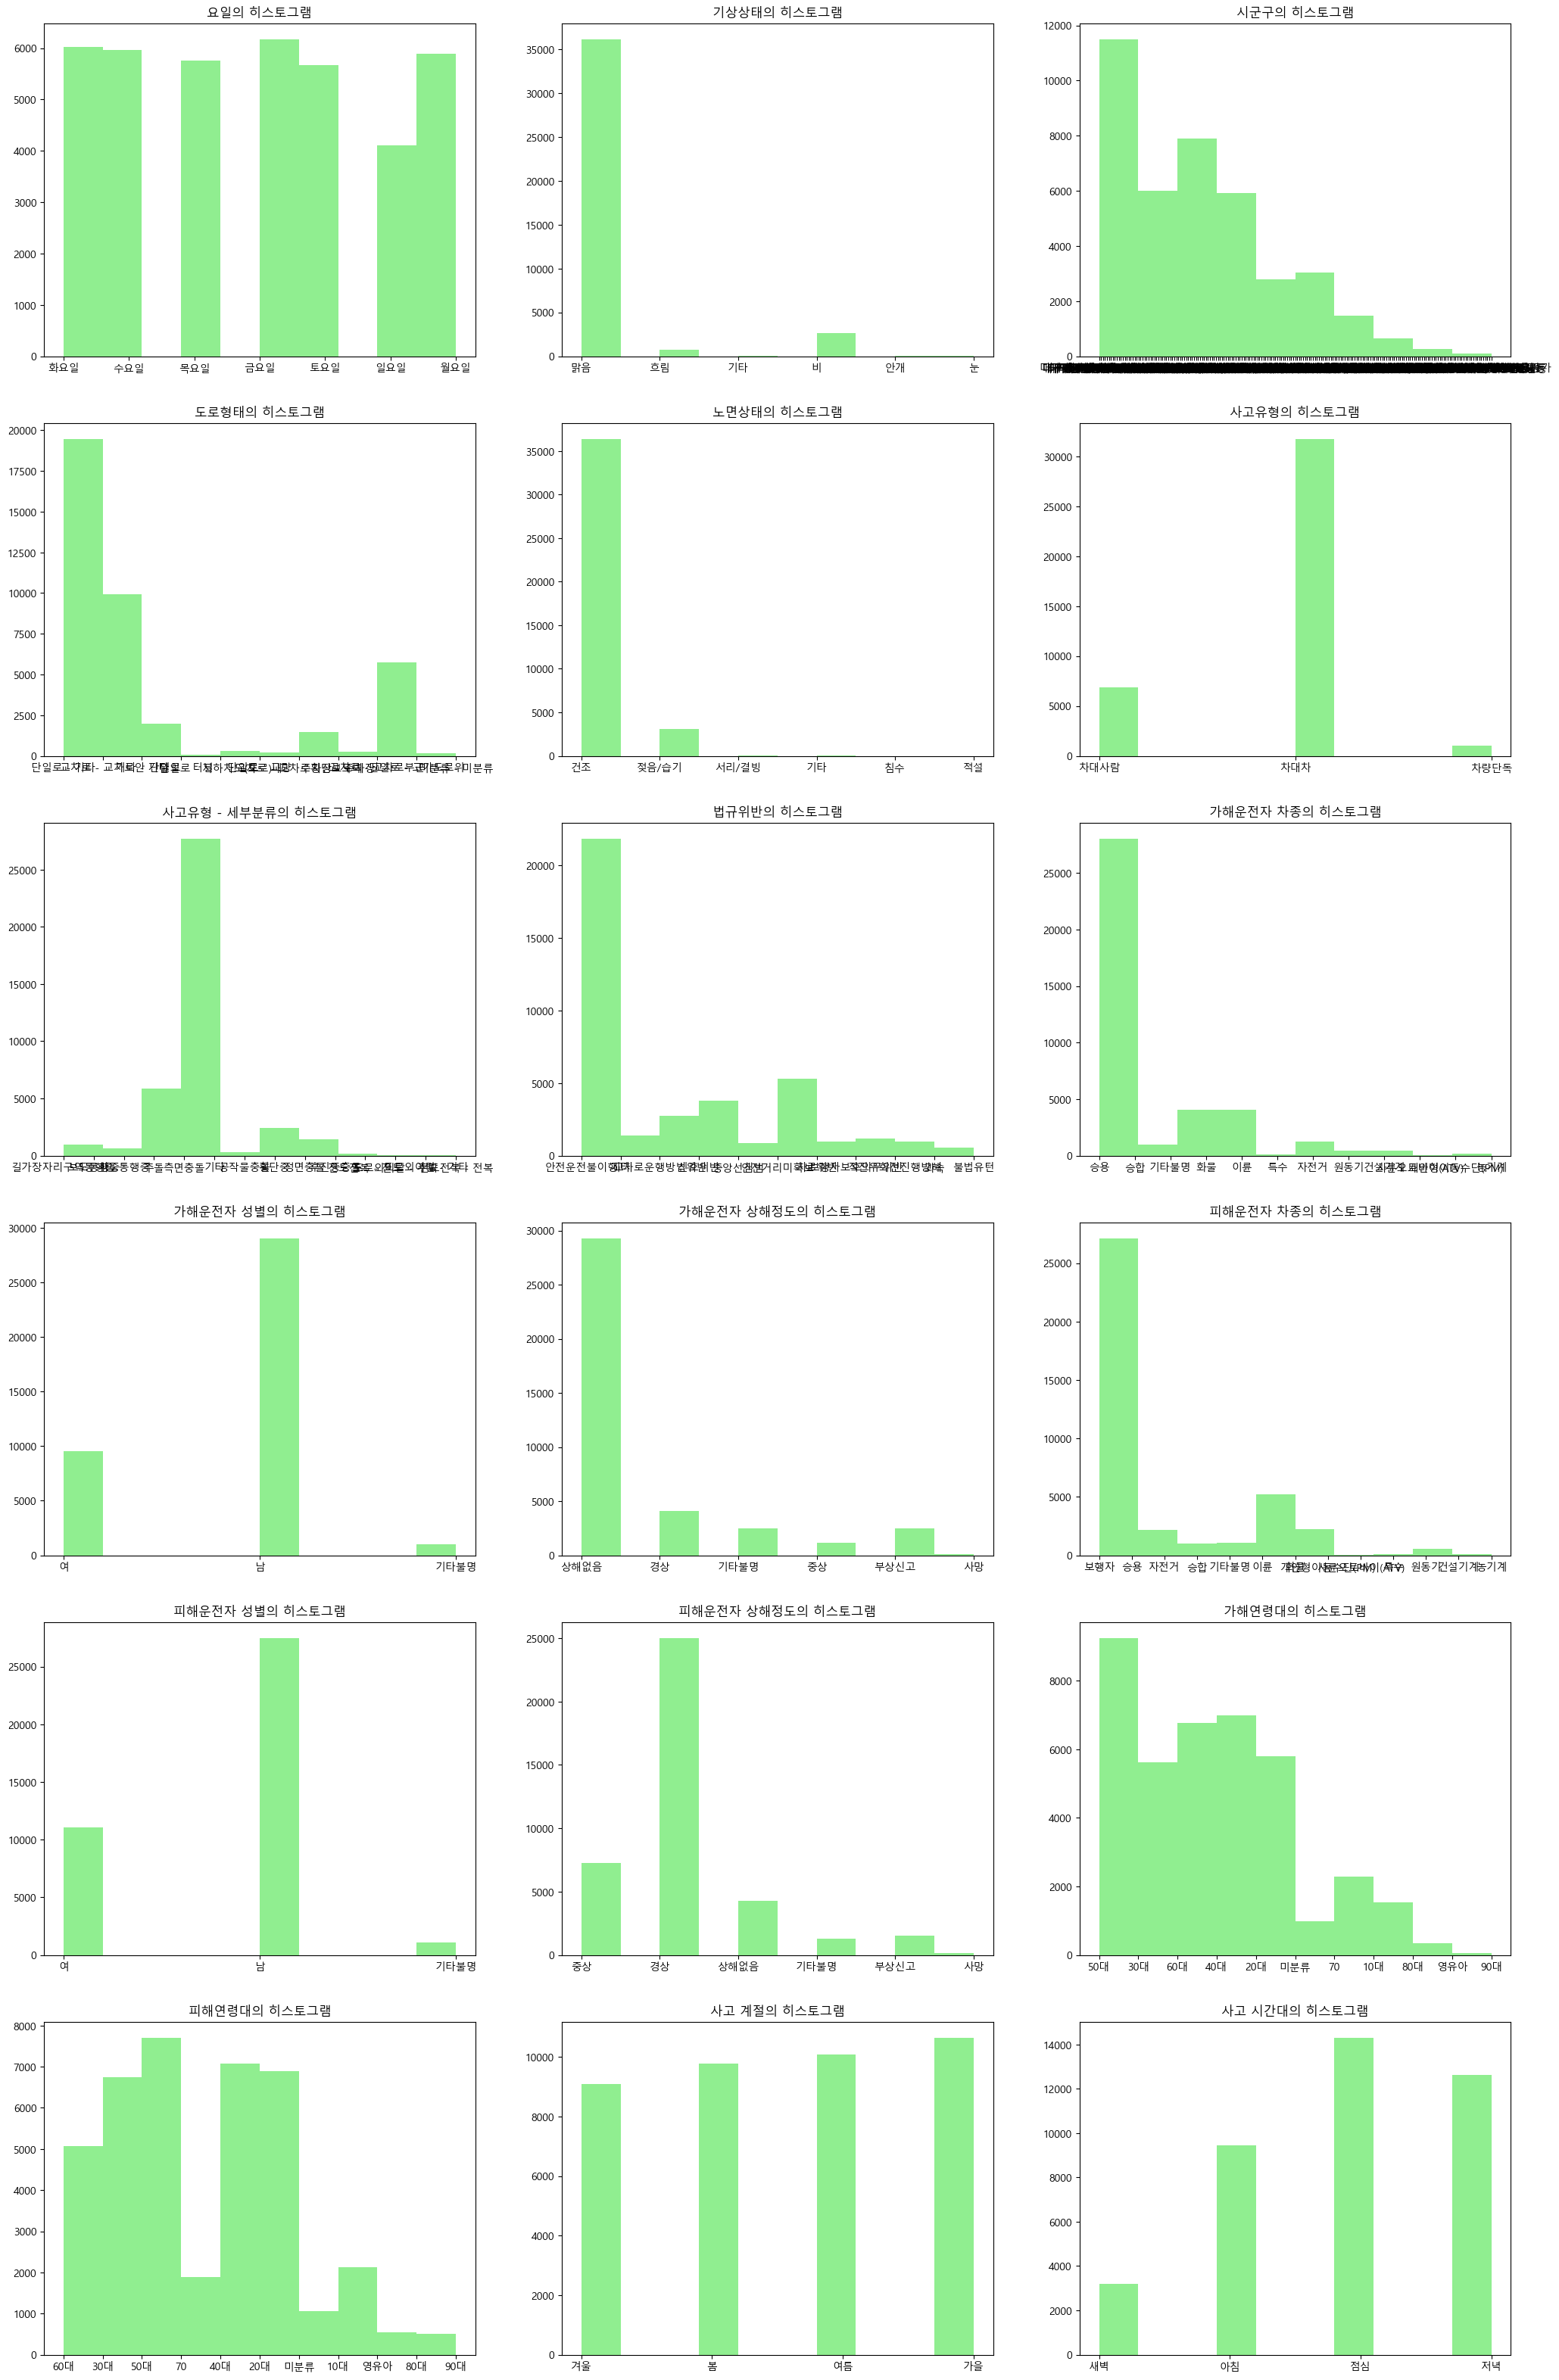

In [129]:
fig, axes = plt.subplots(figsize=(25,40), nrows=6, ncols=3)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

col_ob_sel = object_select.columns

for L in range(len(col_ob_sel)) : 
    ax = axes[L//3][L%3]

    ax.hist(object_select.iloc[:,L], color="lightgreen", align="mid")
    ax.set_title(col_ob_sel[L]+"의 히스토그램")

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

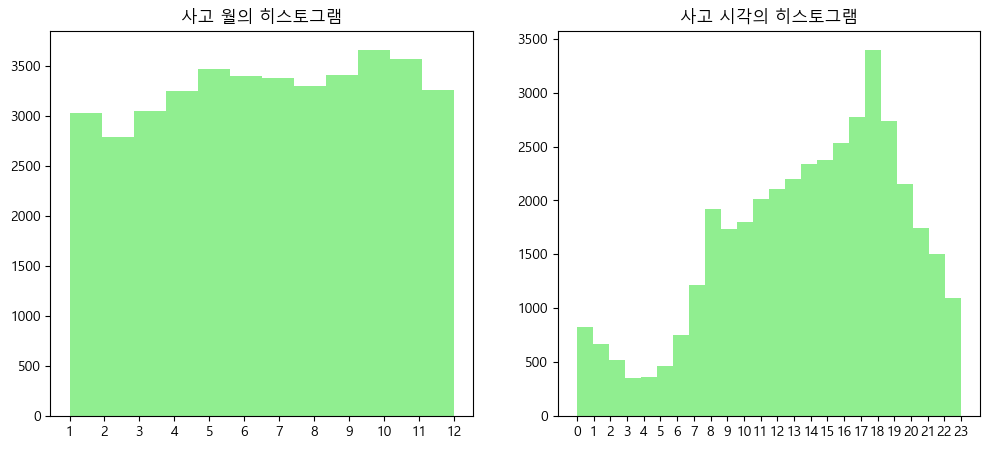

In [130]:
fig, axes = plt.subplots(figsize=(12,5), nrows=1, ncols=2)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

axes[0].hist(df_train_join["사고 월"], color="lightgreen", align="mid", bins=12)
axes[0].set_xticks([i for i in range(1,13)])
axes[0].set_title("사고 월의 히스토그램")
axes[1].hist(df_train_join["사고 시각"], color="lightgreen", align="mid", bins=24)
axes[1].set_xticks([i for i in range(24)])
axes[1].set_title("사고 시각의 히스토그램")


plt.show

겹쳐서 안 보이는 그래프는 따로 보도록 하고  
  
하나하나 살펴보면  
  
- 요일 : 일요일을 제외하면, 요일에 따른 사고는 큰 차이가 없어 보임
- 기상 상태 : 날씨가 안 좋을 때보다 날씨가 좋을 때 사고가 많이 일어남 >> 날씨가 안 좋아서 더욱 조심 or 날씨가 맑을 때 교통량이 많음
- 노면 상태 : 건조할 때 사고가 많음 >> 이는 기상 상태와 연관성을 보이므로 둘 중 하나의 변수 제거 고려
- 사고 유형 : '차대차'가 가장 많음
- 가해 운전자 차종 : 업무용 차보다 승용차가 압도적으로 많음 ↔ 화물이나 이륜도 어느 정도 비율을 차지
- 피해 운전자 차종 : 승용차가 많음 >> 사고가 차대차가 많기 때문
- 가해 운전자 / 피해 운전자 성별 : 남자가 많음 >> 해당 도시에 운전 면허를 가진 사람이 남자가 많을 가능성 ↔ 여성이 운전을 조금 더 조심하게 할 가능성
- 가해 운전자 / 피해 운전자 상해 정도 : 가해 운전자는 상해가 없을 수 있으나 피해 운전자는 경상을 입은 경우가 많음
- 사고 계절 : 계절별 큰 차이는 없으나, 가을이 가장 많고 겨울이 적은 것을 봤을 때 교통량의 차이로 보임
- 사고 시간대 : 새벽이 제일 적고 점심이 제일 많은 것으로 보아 교통량의 차이로 보임. 특히 17~19시가 많은 것을 보아 퇴근 시간대 사고 많이 나는 것으로 보임

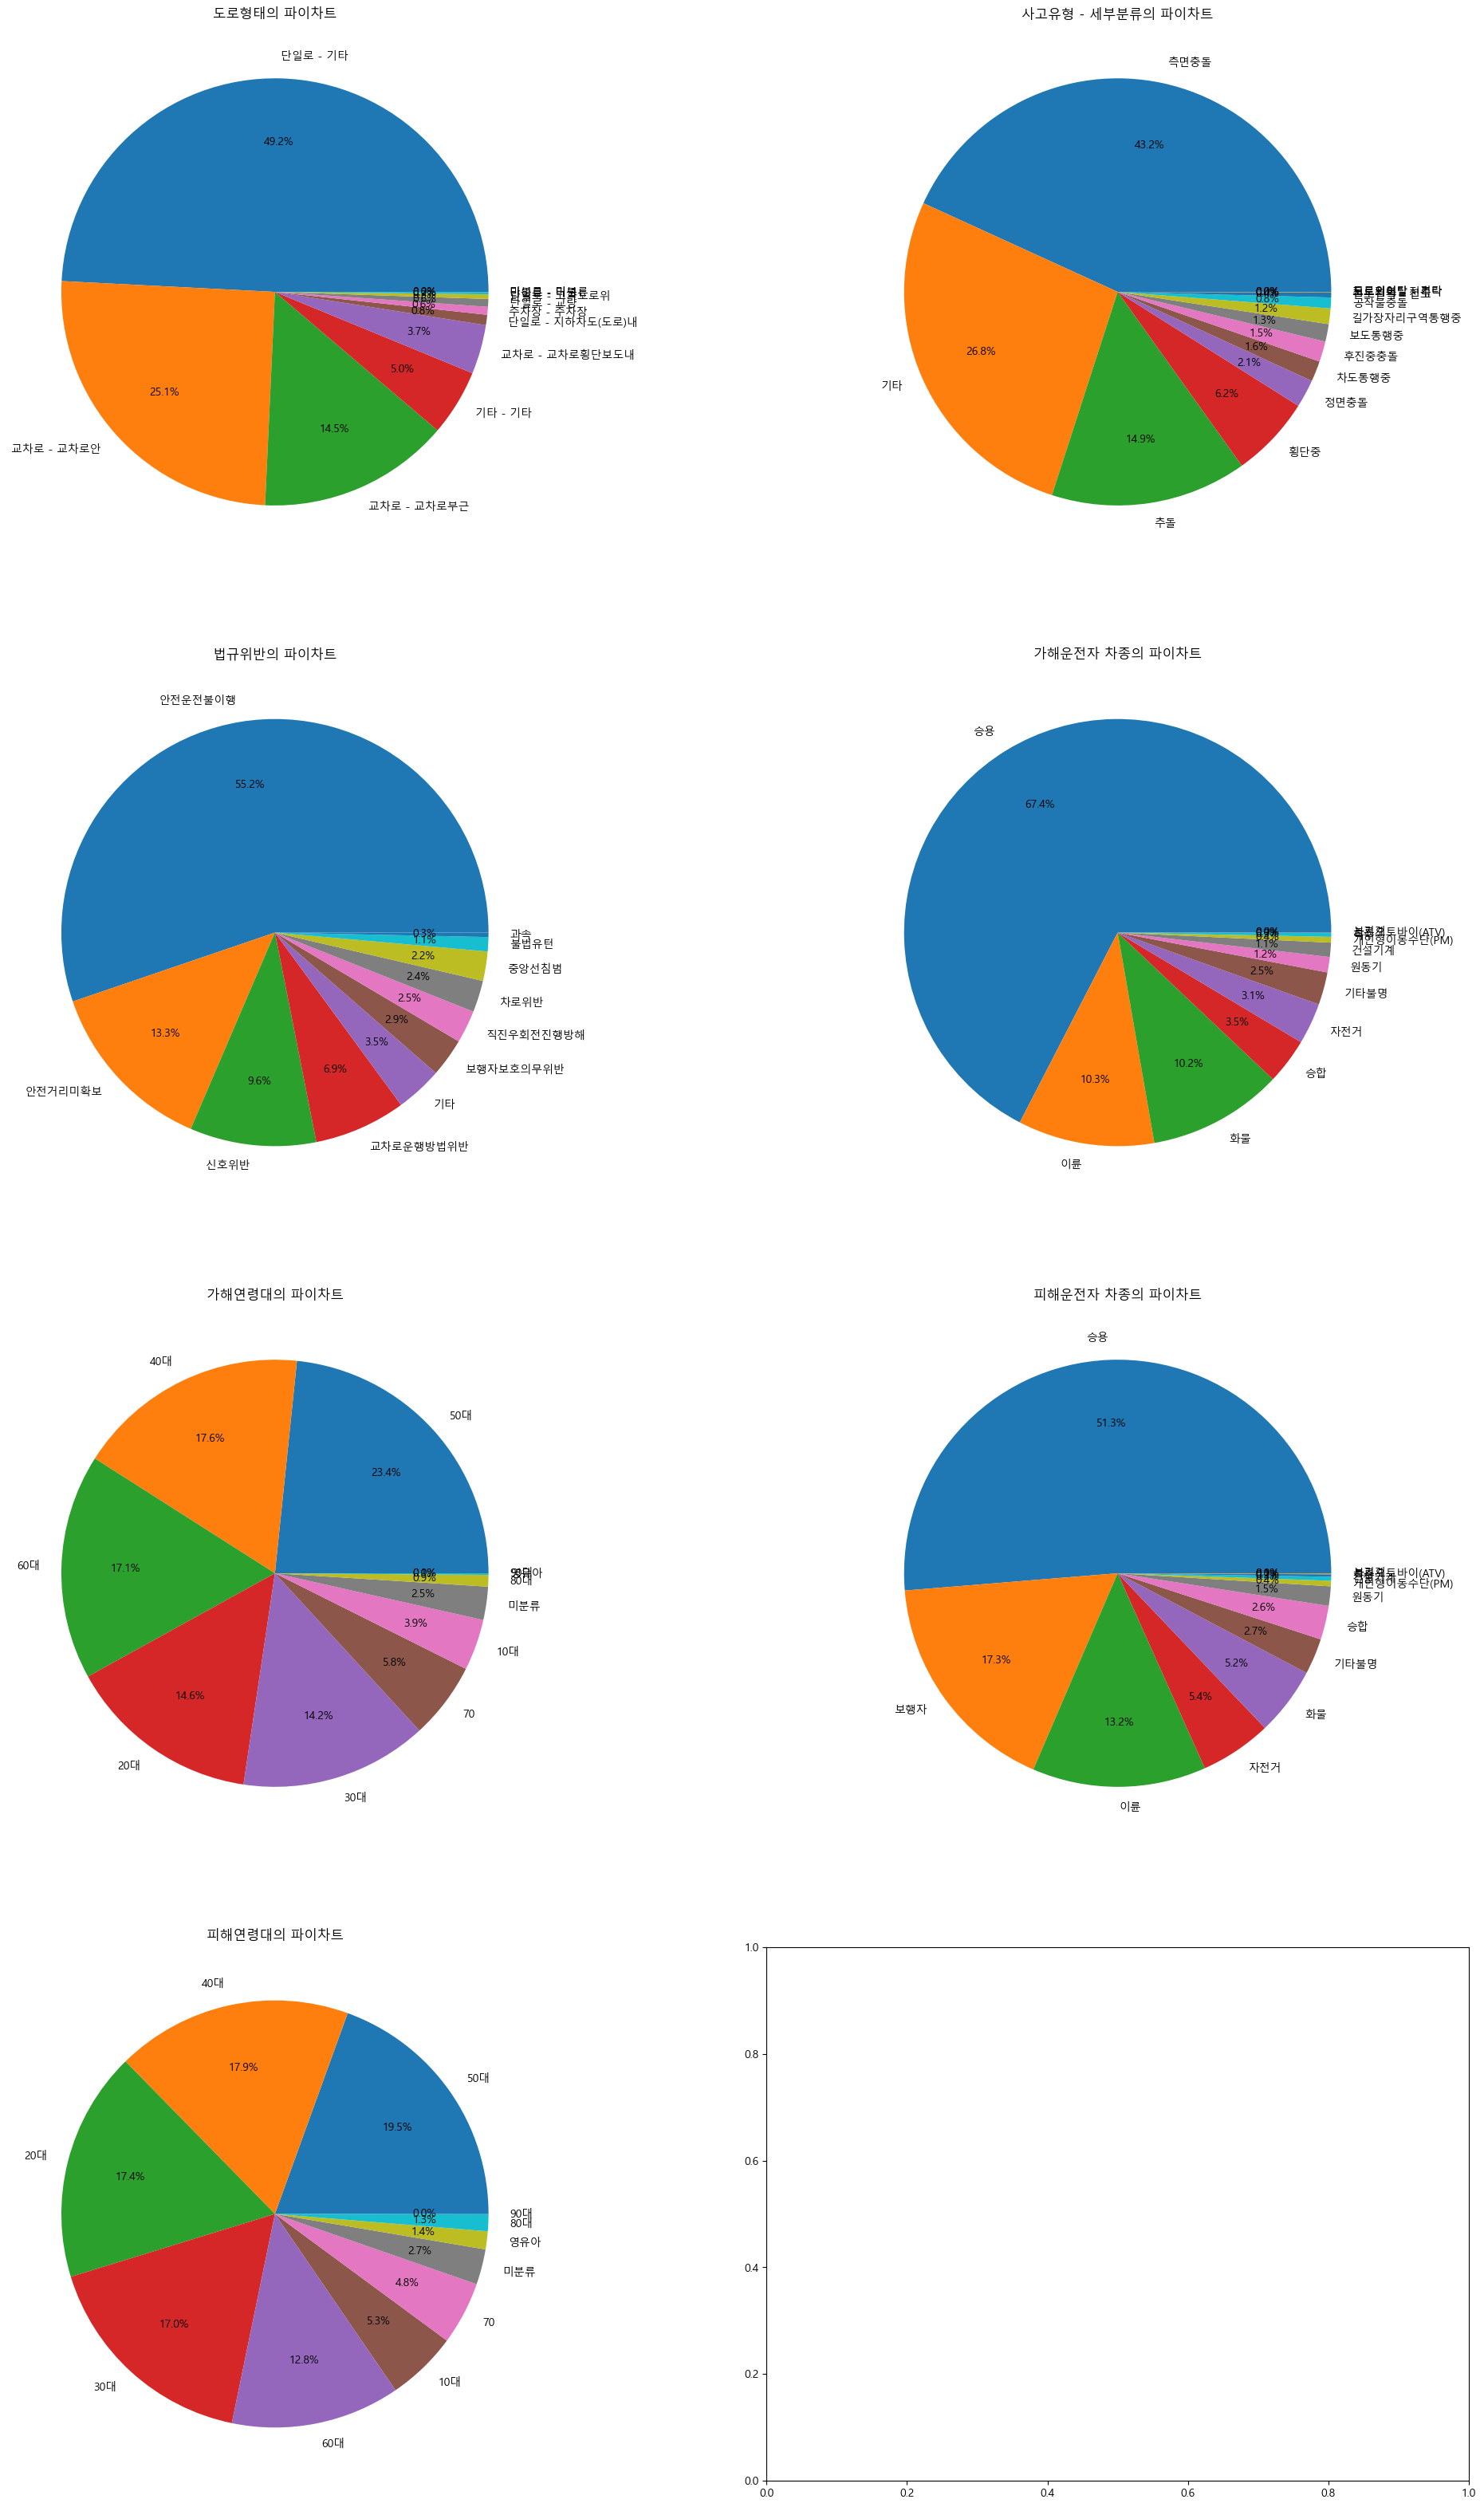

In [131]:
fig, axes = plt.subplots(figsize=(25,40), nrows=4, ncols=2)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

col_ob_sel = object_select.columns

List_pie = ['도로형태', '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해연령대', '피해운전자 차종', '피해연령대']

for L in range(len(List_pie)) : 
    ax = axes[L//2][L%2]

    val_cnt = df_train_join[List_pie[L]].value_counts()

    ax.pie(val_cnt, labels=val_cnt.index, pctdistance=0.7, autopct="%.1f%%")
    ax.set_title(List_pie[L]+"의 파이차트")
    # ax.legend(loc="upper right")

plt.show()

- 도로형태 : 단일로가 제일 많고, 그 다음 교차로 안이 두 번째로 사고가 많음
- 사고유형 - 세부분류 : 측면 충돌이 제일 많고, 기타가 2위, 추돌이 3위 >> 단일로나 교차로에서 측면 충돌이나 추돌이 일어날 가능성이 큼
- 법규위반 : 안전운전 불이행이 가장 많고, 안전거리 미확보가 그 다음  
(안전운전불이행 : 휴대전화, 담배, 라디오 조작, 졸음운전, 전방 주시 태만 사고, 제동장치 조작 불량 사고, 핸들 과대조작 사고 등)
- 가해 연령대 : 50대가 제일 많고 그 뒤로 40대, 60대 >> 차가 있을 확률이 높은 연령대가 사고를 많이 냄
- 피해 연령대 : 50대가 제일 많고 그 뒤로 40대, 20대

종합적으로  
  
1. 언제 : 여름이나 겨울, 퇴근 시간대
2. 어디서 : 단일로나 교차로
3. 누가 : 40~60대 남성
4. 무엇을 : 측면 충돌 혹은 추돌
5. 어떻게 : 안전 운전 불이행 혹은 안전 거리 미확보
6. 왜 : ??

같은 이유로 사고가 날 수 있음

### 카이제곱 검정

가해 운전자의 개인 정보를 알기는 어려우나,  
  
사고가 많이 나는 조건을 안다면,  
  
해당 지역에 사고가 날지 안 날지 예측할 수 있음

---

남성이 여성보다 사고가 많이 났고  
  
특정 연령대에서 사고가 많이 났고  
  
특정 차종이 사고가 많이 난 것이,  
  
대구 성별, 연령, 차종에 비례해서 난 것인지 아닌지에 대한 검증이 필요

In [63]:
# 성별 카이제곱 검정

sex_acc = df_train_join.groupby("가해운전자 성별")["ID"].count().values[1:]

sex_acc

array([29052,  9571], dtype=int64)

In [50]:
car_id = pd.read_csv("./data/external_open/경찰청_운전면허소지자 종별 현황_12_31_2020.csv", encoding="cp949")

car_id.head()

,지역별,성별,1종대형,1종보통,1종소형,대형견인,소형견인,구난,2종보통,2종소형,원자
0,서울,남,253607,2557639,97,24362,4143,14993,1536235,108959,223938
1,서울,여,7503,769668,0,141,173,80,2327886,2799,9767
2,부산,남,129926,946232,32,36015,2109,8357,373081,33476,84702
3,부산,여,2936,288345,0,170,61,49,671835,521,4505
4,대구,남,108466,752564,32,12037,1881,5589,201310,28655,80040


In [64]:
# 대구 지역의 성별 운전면허 소지 현황을 확인

sex_id = car_id[car_id["지역별"]=="대구"]

sex_id[sex_id.columns[2:]] = sex_id[sex_id.columns[2:]].astype(int)

sex_id["합계"] = sex_id[sex_id.columns[2:]].sum(axis=1)

sex_id

,지역별,성별,1종대형,1종보통,1종소형,대형견인,소형견인,구난,2종보통,2종소형,원자,합계
4,대구,남,108466,752564,32,12037,1881,5589,201310,28655,80040,1190574
5,대구,여,2543,293607,0,49,108,18,485510,425,6545,788805


In [65]:
sex_id = sex_id["합계"].to_numpy()

sex_id

array([1190574,  788805], dtype=int64)

In [67]:
sex_no_acc = sex_id - sex_acc

print(sex_no_acc)

chi_sex = np.array([sex_acc, sex_no_acc])   # 성별에 따른 사고를 낸 사람과 내지 않은 사람을 구분

print(chi_sex)

result = chi2_contingency(chi_sex)

if result[1] <= 0.05 : 
    print("유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택")
else : 
    print("유의수준 5%에서 p-value가 0.05보다 작지않으므로 귀무가설 채택")

[1161522  779234]
[[  29052    9571]
 [1161522  779234]]
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택


카이제곱 검정을 했을 때, 성별에 따른 사고 수에 차이가 있는 것으로 나오나  
  
여기에는 큰 맹점이 있다.  
  
왜냐하면  
  
실제로 면허를 따도 운전을 하지 않는 사람이 있기 때문에  
  
운전을 하지 않은 사람은 사고를 낼 가능성이 아예 없다.  
  
성별에 따른 사고에 차이를 검증하기 위해서는  
  
현재 운전을 하는 사람에 대한 통계가 필요하다.  
  
같은 이유로, 연령에 따라 사고가 달리 난다를 검증할 방법이 없다.

차종의 경우도 등록된 차량이 전부 운행한다고 볼 수 없기에,  
  
차종에 따라 사고를 검증할 수 없다.

### 상관성 검정

날씨와 노면 상태, cctv 수, 어린이 보호구역의 수, 어린이 보호구역의 cctv 수, 보안등 수에 따른 ECLO의 상관 계수를 확인.  
  
먼저 날씨는 맑을 때를 1, 흐릴 때를 2, 비 / 안개 /눈을 3으로 설정(날씨가 가혹할수록 가중).  
  
'기타'의 날씨를 가늠할 수 없으므로, 적당한 순위인 '흐림'가 동등하게 설정('기타'=2).
  
노면은 건조를 1, 젖음/습기를 2, 서리/결빙을 3, 침수와 적설을 4로 설정.  
  
서리/결빙을 젖음/습기보다 높게 설정한 이유는  
  
대구/경북 지역은 온도가 높아 추위 관련 재해에 취약하다고 판단했기 때문.  
  
노면 상태의 '기타'도 날씨와 같은 이유로 2로 설정

In [132]:
# 기상상태(날씨) 라벨링

df_train_join["기상상태_label"] = df_train_join["기상상태"].replace(["맑음", "흐림", '기타', '비', '안개', '눈'], [1,2,2,3,3,3])
df_test_join["기상상태_label"] = df_test_join["기상상태"].replace(["맑음", "흐림", '기타', '비', '안개', '눈'], [1,2,2,3,3,3])

df_train_join["기상상태_label"].value_counts()

기상상태_label
1    36181
3     2643
2      785
Name: count, dtype: int64

In [133]:
# 노면 상태 라벨링

df_train_join["노면상태_label"] = df_train_join["노면상태"].replace(['건조', '기타', '젖음/습기', '서리/결빙', '침수', '적설'],[1,2,2,3,3,3])
df_test_join["노면상태_label"] = df_test_join["노면상태"].replace(['건조', '기타', '젖음/습기', '서리/결빙', '침수', '적설'],[1,2,2,3,3,3,])

df_train_join["노면상태_label"].value_counts()

노면상태_label
1    36420
2     3158
3       31
Name: count, dtype: int64

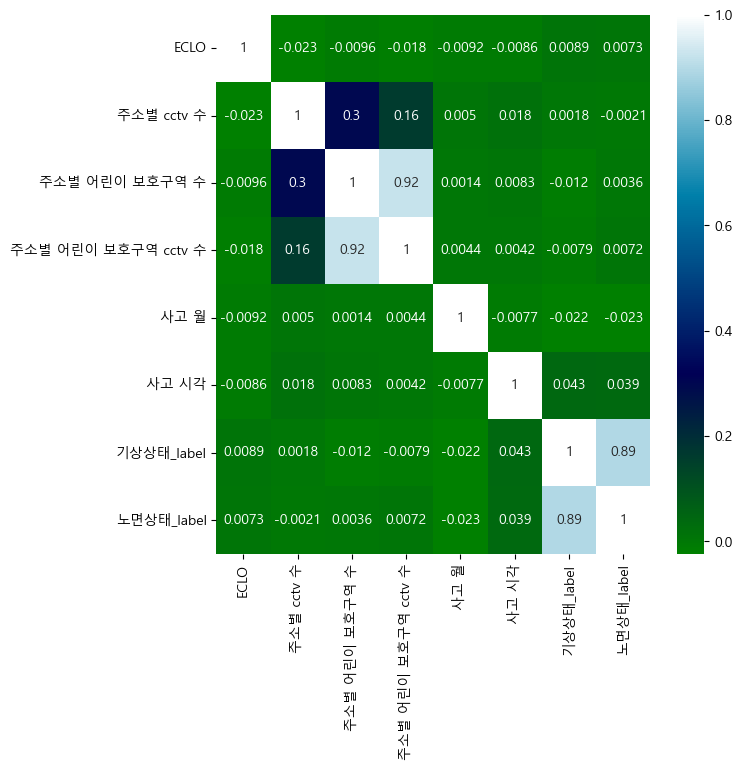

In [134]:
# 숫자 타입의 컬럼만 추출후 상관 관계 분석
# 순위 척도가 포함돼 있으므로 스피어만 상관 계수 사용

number_select = df_train_join.select_dtypes("number").drop(['사망자수','중상자수','경상자수','부상자수'], axis=1)

number_select_corr = number_select.corr("spearman")

plt.figure(figsize=(7,7))
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.family"] = "Malgun Gothic"

sns.heatmap(number_select_corr, annot=True, cmap='ocean')

plt.show()

1. 주소별 cctv 수 - 주소별 어린이 보호구역 수(0.3) : cctv 수는 인구 수에 비례할 것으로 판단하고, 인구 수가 많으면 어린이도 많을 확률이 높기에, 어느 정도 상관성을 보일 것이라고 생각함
2. 주소별 cctv 수 - 주소별 보안등 수(0.48) : 1과 동일한 이유
3. 주소별 어린이 보호구역 수 - 주소별 어린이 보호구역 cctv 수(0.92) : 어린이 보호구역에 cctv를 설치하기 때문에, 어린이 보호구역과 cctv수는 강한 양의 상관 관계 → 둘 중 하나 제거 고려
4. 기상상태_label - 노면상태_label(0.89) : 기상 상태가 안 좋으면 노면 상태도 안 좋을 것이기 때문에, 둘 사이의 강한 양의 상관 관계 → 둘 중 하나 제거 고려

ECLO는 어떠한 변수와도 상관성을 가지지 않는데, 사고가 특정 조건보다는 복합적인 요소로 인해 일어나기 때문으로 생각함

### vif와 pca

변수의 다중공선성을 파악하고, pca를 통해 변수의 중요도를 분산으로 파악하려함

In [135]:
# vif
number_select_dr = number_select.drop("ECLO", axis=1)

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(number_select_dr.values, i) for i in range(len(number_select_dr.columns))]   # i에 따라 vif 값을 리스트에 저장
vif["features"] = number_select_dr.columns

vif.sort_values("VIF", axis=0, ascending=True, inplace=True)

vif

,VIF,features
0,3.13527,주소별 cctv 수
3,4.32058,사고 월
2,5.85987,주소별 어린이 보호구역 cctv 수
4,6.03637,사고 시각
1,8.02240,주소별 어린이 보호구역 수
5,26.26794,기상상태_label
6,44.25477,노면상태_label


In [137]:
# pca

mmsc = MinMaxScaler()

number_select_sc = mmsc.fit_transform(number_select_dr)

df_pca = pd.DataFrame()

df_pca["columns"] = number_select_dr.columns

pca = PCA(n_components=7)

pca.fit(number_select_sc)

df_pca["기여도"] = pca.explained_variance_ratio_

df_pca

,columns,기여도
0,주소별 cctv 수,0.35262
1,주소별 어린이 보호구역 수,0.21686
2,주소별 어린이 보호구역 cctv 수,0.18575
3,사고 월,0.13486
4,사고 시각,0.08267
5,기상상태_label,0.02156
6,노면상태_label,0.00568


vif가 10이상일 때 다중공선성이 의심된다.  
  
'기상상태_label'과 '노면상태_label'이 vif가 10이상인데,  
  
'기상상태_label'과 '노면상태_label'이 상관성이 강했기에, 수치가 더 큰 '노면상태_label'을 제거했을 때 vif가 변할 수도 있음.  
  
또한 pca를 통해 분산이 가장 큰 변수를 살펴봤을 때,  
  
'주소별 cctv 수'가 가장 분산이 커 기여도가 크고, 두 번째가 '주소별 어린이 보호구역 수'이므로,  
  
상관 계수가 컸던 '주소별 어린이 보호구역 수'와 '주소별 어린이 보호구역 cctv 수' 중 후자를 제거하는 것을 고려하면 될 것이다.

### 공간데이터 열기

<Axes: >

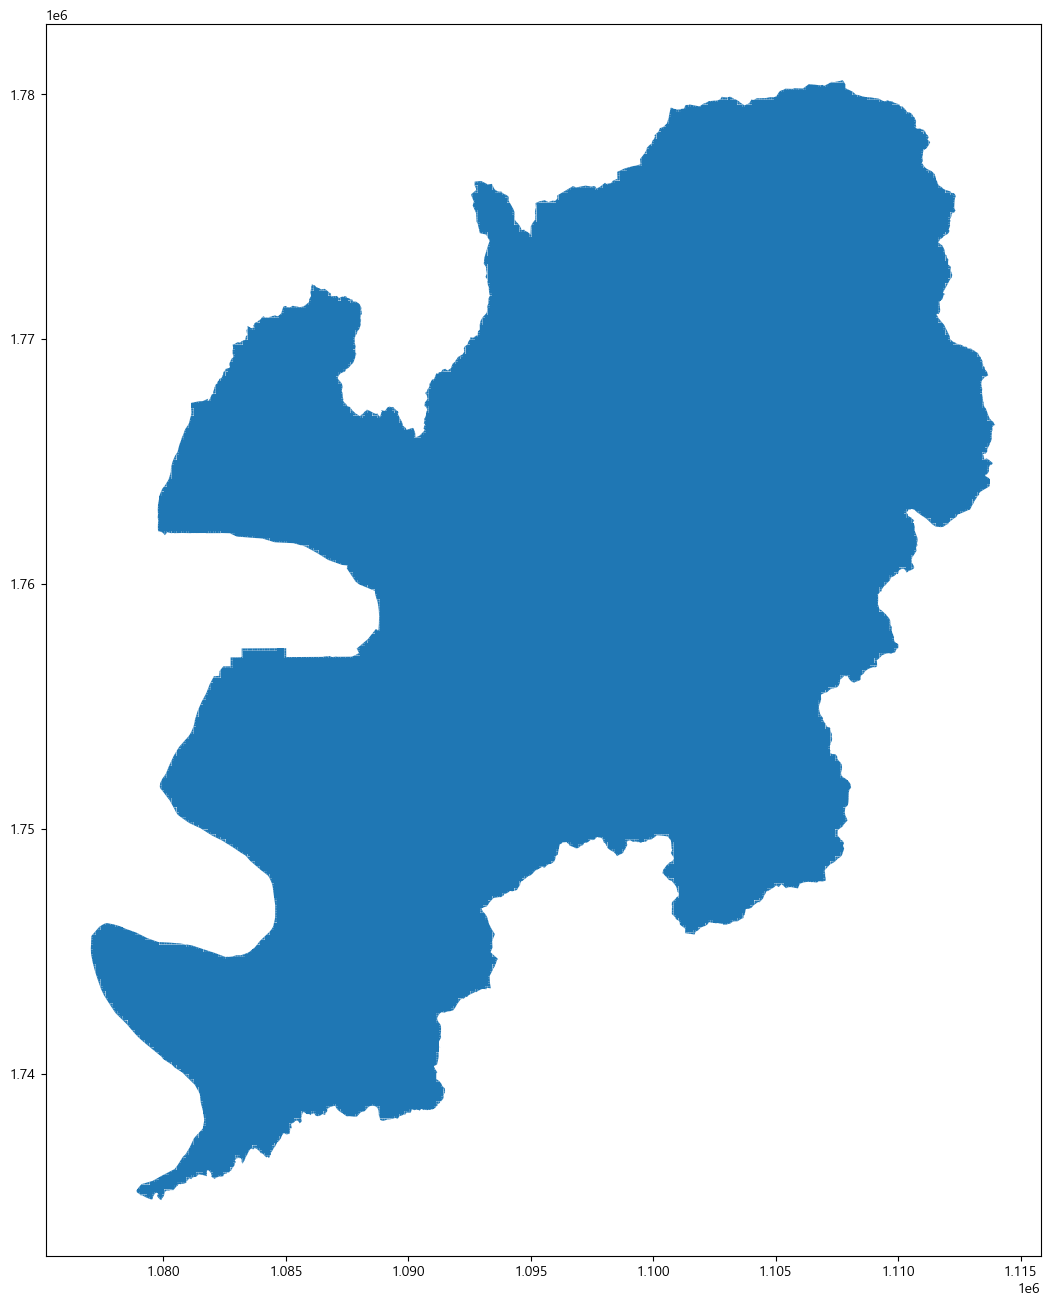

In [149]:
daegu100 = gpd.read_file("./data/external_open/대구 빅데이터 마트 데이터/0. Base/대구광역시_100.gpkg")

daegu100.plot(figsize=(16,16))

In [198]:
traffic100 = gpd.read_file("./data/external_open/대구 빅데이터 마트 데이터/5. 통행/3. 도로정보 및 교통량(합계, 시간대별)/교통데이터_시간대별/교통데이터_시간대별_100.gpkg", engine="pyogrio",encoding='cp949')

In [186]:
traffic100.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Columns: 146 entries, id to geometry
dtypes: float64(144), geometry(1), int64(1)
memory usage: 99.5 MB


In [200]:
traffic100.isnull().sum()

id                    0
시간_평균속도_mean_0    79874
시간_평균속도_mean_1    79874
시간_평균속도_mean_2    79874
시간_평균속도_mean_3    79874
                  ...  
시간_밀도_mean_20     80003
시간_밀도_mean_21     80003
시간_밀도_mean_22     80003
시간_밀도_mean_23     80003
geometry              0
Length: 146, dtype: int64

밀도(승용차/km/차로)

: 어느시간에 단위구간 도로상에 있는 차량대수 (대/km/시간)

- 고속도로 통행시 앞뒤차량과의 거리를 나타내므로

고속도로구간의 서비스수준을 나타내는 주요 효과척도임

In [257]:
traffic100_dr_index = traffic100.drop("geometry", axis=1).dropna(axis=0, how="all").index

traffic100_dr = traffic100.iloc[traffic100_dr_index].to_crs(crs=4326)

In [258]:
traffic100_dr.shape

(89316, 146)

In [259]:
traffic100_dr.fillna(0, inplace=True)

In [260]:
# 동일 geometry로 groupby

traffic_dense_per_time = traffic100_dr.groupby("geometry")[["시간_밀도_mean_0","시간_밀도_mean_1","시간_밀도_mean_2","시간_밀도_mean_3","시간_밀도_mean_4","시간_밀도_mean_5",
                                "시간_밀도_mean_6","시간_밀도_mean_7","시간_밀도_mean_8","시간_밀도_mean_9","시간_밀도_mean_10","시간_밀도_mean_11",
                                "시간_밀도_mean_12","시간_밀도_mean_13","시간_밀도_mean_14","시간_밀도_mean_15","시간_밀도_mean_16","시간_밀도_mean_17",
                                "시간_밀도_mean_18","시간_밀도_mean_19","시간_밀도_mean_20","시간_밀도_mean_21","시간_밀도_mean_22","시간_밀도_mean_23"]].mean()

traffic_dense_per_time.head()

,시간_밀도_mean_0,시간_밀도_mean_1,시간_밀도_mean_2,시간_밀도_mean_3,시간_밀도_mean_4,시간_밀도_mean_5,시간_밀도_mean_6,시간_밀도_mean_7,시간_밀도_mean_8,시간_밀도_mean_9,...,시간_밀도_mean_14,시간_밀도_mean_15,시간_밀도_mean_16,시간_밀도_mean_17,시간_밀도_mean_18,시간_밀도_mean_19,시간_밀도_mean_20,시간_밀도_mean_21,시간_밀도_mean_22,시간_밀도_mean_23
geometry,,,,,,,,,,,,,,,,,,,,,
"MULTIPOLYGON (((128.37817 35.61359, 128.37816 ...",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
"MULTIPOLYGON (((128.37706 35.61333, 128.37706 ...",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
"MULTIPOLYGON (((128.37416 35.60814, 128.37371 ...",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
"MULTIPOLYGON (((128.37325 35.60838, 128.37274 ...",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
"MULTIPOLYGON (((128.37371 35.60962, 128.37481 ...",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [261]:
# 시간대 별로 분리

for i in range(24) : 
    globals()["tdpt_"+str(i)] = traffic_dense_per_time.loc[:,'시간_밀도_mean_'+str(i)]
    globals()["tdpt_"+str(i)] = globals()["tdpt_"+str(i)].reset_index()
    globals()["tdpt_"+str(i)] = globals()["tdpt_"+str(i)][['시간_밀도_mean_'+str(i), "geometry"]]
    globals()["tdpt_"+str(i)] = gpd.GeoDataFrame(globals()["tdpt_"+str(i)], geometry=globals()["tdpt_"+str(i)]["geometry"])
    
    print('시간_밀도_mean_'+str(i)+" 분리 성공")

시간_밀도_mean_0 분리 성공
시간_밀도_mean_1 분리 성공
시간_밀도_mean_2 분리 성공
시간_밀도_mean_3 분리 성공
시간_밀도_mean_4 분리 성공
시간_밀도_mean_5 분리 성공
시간_밀도_mean_6 분리 성공
시간_밀도_mean_7 분리 성공
시간_밀도_mean_8 분리 성공
시간_밀도_mean_9 분리 성공
시간_밀도_mean_10 분리 성공
시간_밀도_mean_11 분리 성공
시간_밀도_mean_12 분리 성공
시간_밀도_mean_13 분리 성공
시간_밀도_mean_14 분리 성공
시간_밀도_mean_15 분리 성공
시간_밀도_mean_16 분리 성공
시간_밀도_mean_17 분리 성공
시간_밀도_mean_18 분리 성공
시간_밀도_mean_19 분리 성공
시간_밀도_mean_20 분리 성공
시간_밀도_mean_21 분리 성공
시간_밀도_mean_22 분리 성공
시간_밀도_mean_23 분리 성공


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


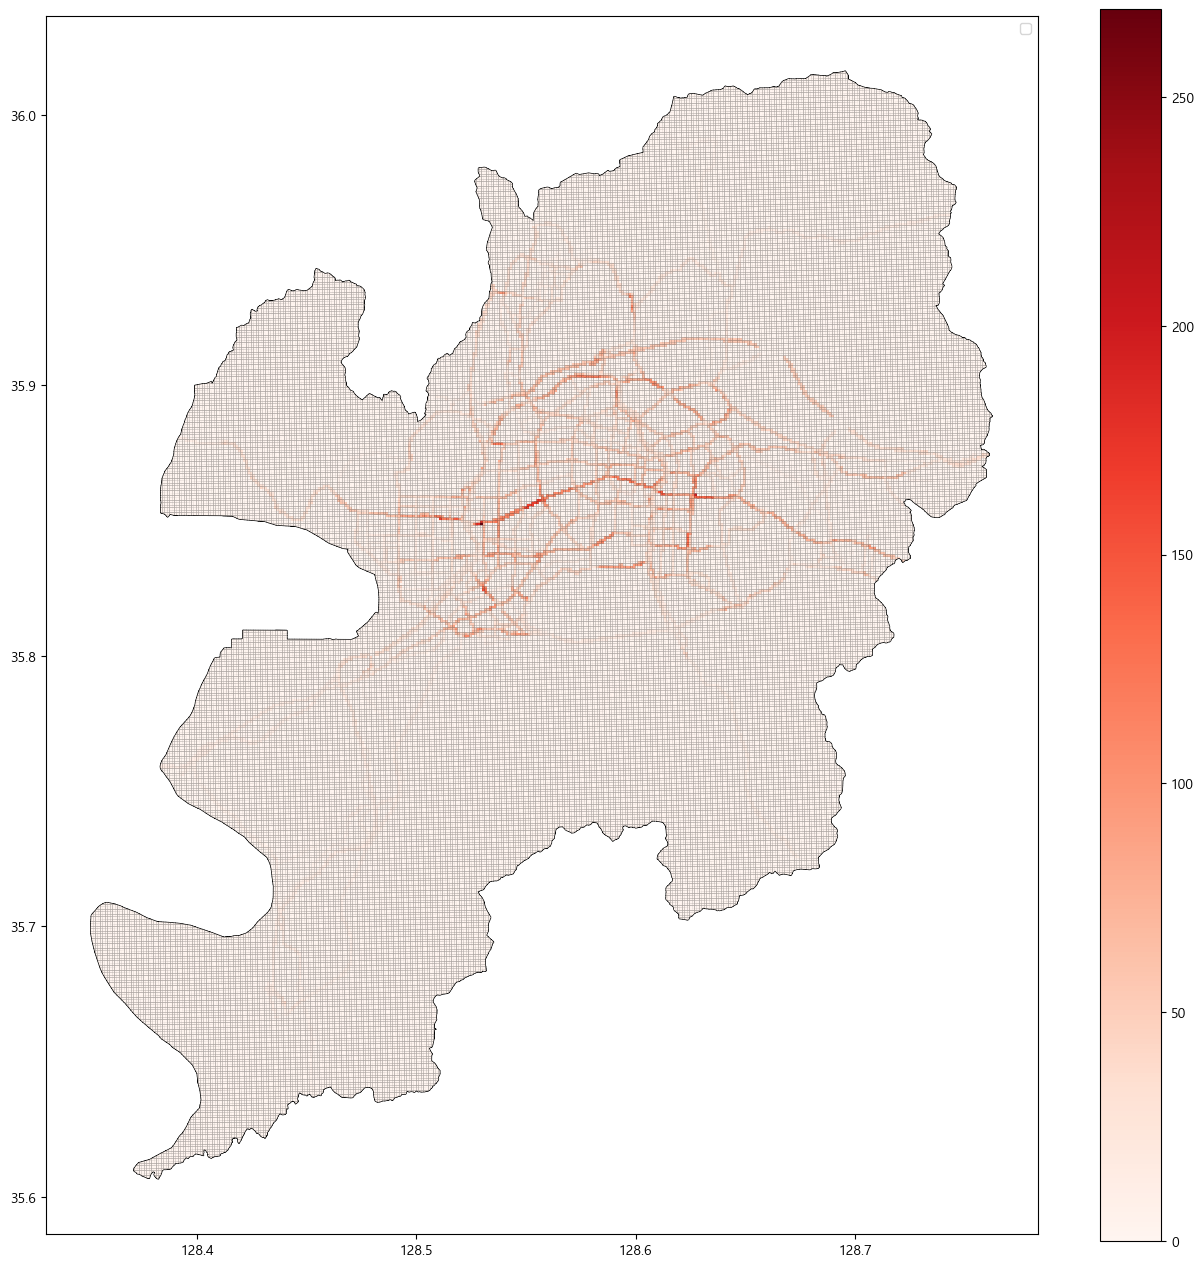

In [265]:
ax = traffic100_dr["geometry"].plot(color="white", edgecolor="black", figsize=(16,16))

tdpt_17.plot(column="시간_밀도_mean_17", ax=ax, cmap='Reds', legend=True)

# plt.legend()

plt.show()

In [256]:
tdpt_17

,시간_밀도_mean_17,geometry
0,0.00000,"MULTIPOLYGON (((128.37245 35.60885, 128.37192 ..."
1,0.00000,"MULTIPOLYGON (((128.37254 35.60873, 128.37259 ..."
2,0.00000,"MULTIPOLYGON (((128.37325 35.60838, 128.37274 ..."
3,0.00000,"MULTIPOLYGON (((128.37260 35.60963, 128.37371 ..."
4,0.00000,"MULTIPOLYGON (((128.37136 35.60941, 128.37125 ..."
...,...,...
89311,0.00000,"MULTIPOLYGON (((128.61872 35.70522, 128.61825 ..."
89312,0.00000,"MULTIPOLYGON (((128.61767 35.70588, 128.61794 ..."
89313,0.00000,"MULTIPOLYGON (((128.61745 35.70602, 128.61741 ..."
89314,0.00000,"MULTIPOLYGON (((128.61712 35.70735, 128.61710 ..."


In [245]:
coor_daegu = gpd.read_file("./data/2017년_행정구역_경계_대구광역시_읍면동단위.shp")

coor_daegu.head()

,zone_id,name,full_name,sido_id,sigungu_id,X,Y,area,geometry
0,2201054,삼덕동,대구광역시 중구 삼덕동,22000,22010,454785.83903,362968.83257,643480.34344,"POLYGON ((344673.336 364554.638, 344694.592 36..."
1,2201056,성내1동,대구광역시 중구 성내1동,22000,22010,454124.69016,363330.79032,774865.61955,"POLYGON ((344267.057 365394.720, 344277.761 36..."
2,2201059,성내2동,대구광역시 중구 성내2동,22000,22010,453401.78501,363564.09439,940529.32825,"POLYGON ((343506.180 365577.065, 343518.182 36..."
3,2201061,성내3동,대구광역시 중구 성내3동,22000,22010,452793.92663,364042.00421,749855.70468,"POLYGON ((343051.299 365699.891, 343066.241 36..."
4,2201062,대신동,대구광역시 중구 대신동,22000,22010,452482.62286,363194.30971,493573.99702,"POLYGON ((342851.810 365158.812, 342863.182 36..."


In [283]:
coor_daegu2 = gpd.read_file("./data/AL_00_D001_20211204/AL_00_D001_20211204(EMD).shp")

coor_daegu2.head()

,A0,A1,A2,A3,geometry
0,292,11110186,½Å¿µµ¿,2021-06-24,"POLYGON ((196551.461 456090.765, 196558.761 45..."
1,293,11110169,ÇýÈ­µ¿,2021-06-24,"POLYGON ((200014.611 454443.230, 200029.874 45..."
2,294,11110184,ºÎ¾Ïµ¿,2021-06-24,"POLYGON ((196500.331 455241.312, 196505.484 45..."
3,295,11110140,»ïÃ»µ¿,2021-06-24,"POLYGON ((197597.735 454551.233, 197599.083 45..."
4,296,11110101,Ã»¿îµ¿,2021-06-24,"POLYGON ((196524.180 453809.271, 196541.748 45..."


<Axes: >

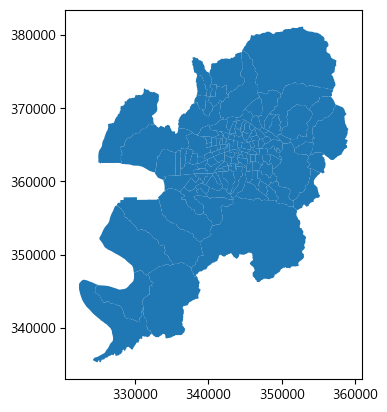

In [246]:
coor_daegu.plot()

In [266]:
# coor_daegu["full_name"].unique()

In [250]:
# 대구 좌표 crs 변경
coor_daegu = coor_daegu.to_crs(crs=4326)

coor_daegu["geometry"]

0      POLYGON ((128.60183 35.86774, 128.60206 35.867...
1      POLYGON ((128.59748 35.87537, 128.59760 35.875...
2      POLYGON ((128.58909 35.87712, 128.58922 35.877...
3      POLYGON ((128.58408 35.87830, 128.58424 35.878...
4      POLYGON ((128.58177 35.87345, 128.58190 35.873...
                             ...                        
134    POLYGON ((128.45780 35.94157, 128.45820 35.941...
135    POLYGON ((128.44093 35.80604, 128.44103 35.806...
136    POLYGON ((128.44678 35.71975, 128.44670 35.718...
137    POLYGON ((128.51101 35.72643, 128.51219 35.726...
138    POLYGON ((128.44876 35.67224, 128.44814 35.672...
Name: geometry, Length: 139, dtype: geometry

In [269]:
coor_tdpt_17 = tdpt_17.sjoin(coor_daegu, how="inner", predicate='intersects')

coor_tdpt_17

,시간_밀도_mean_17,geometry,index_right,zone_id,name,full_name,sido_id,sigungu_id,X,Y,area
0,0.00000,"MULTIPOLYGON (((128.37817 35.61359, 128.37816 ...",138,2231036,구지면,대구광역시 달성군 구지면,22000,22310,436703.42043,339753.94946,38892662.49380
1,0.00000,"MULTIPOLYGON (((128.37706 35.61333, 128.37706 ...",138,2231036,구지면,대구광역시 달성군 구지면,22000,22310,436703.42043,339753.94946,38892662.49380
2,0.00000,"MULTIPOLYGON (((128.37416 35.60814, 128.37371 ...",138,2231036,구지면,대구광역시 달성군 구지면,22000,22310,436703.42043,339753.94946,38892662.49380
3,0.00000,"MULTIPOLYGON (((128.37325 35.60838, 128.37274 ...",138,2231036,구지면,대구광역시 달성군 구지면,22000,22310,436703.42043,339753.94946,38892662.49380
4,0.00000,"MULTIPOLYGON (((128.37371 35.60962, 128.37481 ...",138,2231036,구지면,대구광역시 달성군 구지면,22000,22310,436703.42043,339753.94946,38892662.49380
...,...,...,...,...,...,...,...,...,...,...,...
79855,0.00000,"MULTIPOLYGON (((128.67676 35.79637, 128.67786 ...",105,2206071,고산1동,대구광역시 수성구 고산1동,22000,22060,463406.49049,357083.15236,8856951.89079
79856,0.00000,"MULTIPOLYGON (((128.67786 35.79636, 128.67897 ...",105,2206071,고산1동,대구광역시 수성구 고산1동,22000,22060,463406.49049,357083.15236,8856951.89079
79857,0.00000,"MULTIPOLYGON (((128.67788 35.79726, 128.67898 ...",105,2206071,고산1동,대구광역시 수성구 고산1동,22000,22060,463406.49049,357083.15236,8856951.89079
79858,0.00000,"MULTIPOLYGON (((128.67789 35.79817, 128.67900 ...",105,2206071,고산1동,대구광역시 수성구 고산1동,22000,22060,463406.49049,357083.15236,8856951.89079


In [279]:
coor_daegu[coor_daegu["full_name"].str.contains("수성")]

,zone_id,name,full_name,sido_id,sigungu_id,X,Y,area,geometry
85,2206051,범어1동,대구광역시 수성구 범어1동,22000,22060,456829.94329,361707.52346,1163488.85189,"POLYGON ((128.62260 35.85941, 128.62327 35.859..."
86,2206052,범어2동,대구광역시 수성구 범어2동,22000,22060,457392.82681,362722.30342,1024621.04995,"POLYGON ((128.63710 35.86683, 128.63811 35.866..."
87,2206053,범어3동,대구광역시 수성구 범어3동,22000,22060,456458.48731,362859.85546,579123.89590,"POLYGON ((128.61799 35.86781, 128.61845 35.867..."
88,2206054,범어4동,대구광역시 수성구 범어4동,22000,22060,457841.11098,361740.37676,1099932.46807,"POLYGON ((128.64280 35.85886, 128.64280 35.858..."
89,2206055,만촌1동,대구광역시 수성구 만촌1동,22000,22060,458856.73751,363623.29995,2786546.81784,"POLYGON ((128.65109 35.87833, 128.65126 35.878..."
90,2206056,만촌2동,대구광역시 수성구 만촌2동,22000,22060,458882.58612,362593.89069,1776721.07871,"POLYGON ((128.65000 35.86602, 128.65002 35.865..."
91,2206057,만촌3동,대구광역시 수성구 만촌3동,22000,22060,458925.18621,361380.46465,1792083.88558,"POLYGON ((128.64644 35.85884, 128.64796 35.858..."
92,2206058,수성1가동,대구광역시 수성구 수성1가동,22000,22060,455373.94632,361847.38270,585392.55471,"POLYGON ((128.60851 35.84907, 128.60841 35.849..."
93,2206059,수성2·3가동,대구광역시 수성구 수성2·3가동,22000,22060,455958.47371,361871.48262,646350.30664,"POLYGON ((128.61992 35.85944, 128.62019 35.859..."
94,2206060,수성4가동,대구광역시 수성구 수성4가동,22000,22060,455840.07339,362693.86403,631024.95908,"POLYGON ((128.61513 35.86775, 128.61525 35.867..."


In [282]:
coor_daegu_unique = pd.DataFrame(coor_daegu["full_name"].unique())
train_unique = pd.DataFrame(df_train_join["시군구"].unique())

coor_daegu_unique.to_csv('G:/내 드라이브/데이콘/사고 예측/coor_daegu_unique.csv', encoding="cp949")
train_unique.to_csv('G:/내 드라이브/데이콘/사고 예측/train_unique.csv', encoding="cp949")

In [277]:
df_train_join[df_train_join["시군구"].str.contains("가")]

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,피해연령대,주소별 cctv 수,주소별 어린이 보호구역 수,주소별 어린이 보호구역 cctv 수,사고 월,사고 시각,사고 계절,사고 시간대,기상상태_label,노면상태_label
25,ACCIDENT_00025,2019-01-02 10:00:00,수요일,맑음,대구광역시 달성군 유가읍,주차장 - 주차장,건조,차대사람,횡단중,안전운전불이행,...,50대,16,6,0,1,10,겨울,아침,1,1
41,ACCIDENT_00041,2019-01-02 17:00:00,수요일,맑음,대구광역시 달성군 유가읍,교차로 - 교차로부근,건조,차대차,기타,안전운전불이행,...,20대,16,6,0,1,17,겨울,점심,1,1
42,ACCIDENT_00042,2019-01-02 18:00:00,수요일,맑음,대구광역시 수성구 수성동4가,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,50대,1,4,3,1,18,겨울,저녁,1,1
43,ACCIDENT_00043,2019-01-02 18:00:00,수요일,맑음,대구광역시 북구 노원동3가,단일로 - 기타,건조,차대차,기타,안전거리미확보,...,50대,2,0,0,1,18,겨울,저녁,1,1
57,ACCIDENT_00057,2019-01-03 05:00:00,목요일,맑음,대구광역시 북구 노원동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,60대,2,0,0,1,5,겨울,새벽,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39529,ACCIDENT_39529,2021-12-29 21:00:00,수요일,맑음,대구광역시 달성군 유가읍,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,40대,16,6,0,12,21,겨울,저녁,1,1
39542,ACCIDENT_39542,2021-12-30 12:00:00,목요일,맑음,대구광역시 북구 칠성동2가,교차로 - 교차로횡단보도내,건조,차대사람,보도통행중,보행자보호의무위반,...,20대,3,4,4,12,12,겨울,점심,1,1
39572,ACCIDENT_39572,2021-12-31 10:00:00,금요일,맑음,대구광역시 북구 칠성동2가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,50대,3,4,4,12,10,겨울,아침,1,1
39591,ACCIDENT_39591,2021-12-31 16:00:00,금요일,맑음,대구광역시 중구 삼덕동2가,단일로 - 기타,건조,차대차,정면충돌,안전운전불이행,...,30대,3,1,1,12,16,겨울,점심,1,1


### 연습

In [7]:
# 좌표 정의

x1, y1 = 1,2
x2, y2 = 2,2
x3, y3 = 2,3
x4, y4 = 1,3

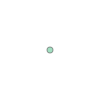

In [13]:
point = Point([x1, y1])
point

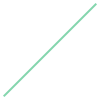

In [14]:
line = LineString([(x1,y1),(x3,y3)])
line

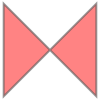

In [10]:
Polygon([(x2,y2),(x3,y3),(x1,y1),(x4,y4)])

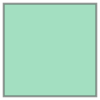

In [15]:
polygon = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)])
polygon

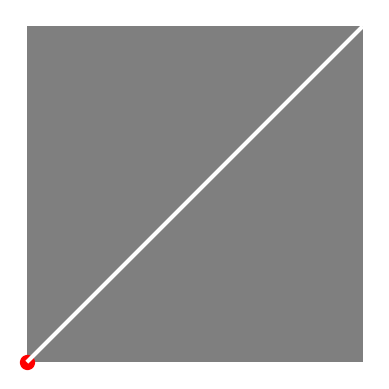

Point
LineString
Polygon


In [19]:
# 공간데이터 시각화

ax = gpd.GeoSeries(polygon).plot(color='black', alpha=0.5)

gpd.GeoSeries(line).plot(ax=ax, linewidth=3, color='white')

gpd.GeoSeries(point).plot(ax=ax, color="red", markersize=100)

plt.axis("off")

plt.show()

print(point.geom_type)
print(line.geom_type)
print(polygon.geom_type)